In [564]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pandas.plotting import table
from IPython.display import clear_output
import warnings
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.formula.api import ols

In [565]:
class Indicator:
    
    def __init__(self, df, name, number, var, i_cal, i_type, description, period, target):
        """
        - Initialise the Indicator class

        name: str, Name of the indicator
        number: int, Number associated with the indicator
        var: list, Variable of the indicator (Questions)
        i_cal: str, How to calculate the indicator
        i_type: str, Type of the indicator ('Count' or 'Percentage')
        description: str, Description of the indicator
        period: str, Period when the indicator is measured ('baseline', 'midline', or 'endline')
        targets: int, Target for this survey
        score_map: dic, Way to calculate the score for this indicator
        """
        self.df = df
        self.name = name
        self.number = number
        self.var = var
        if len(var) == 1:
            self.var_type = 'single'
        else: self.var_type = 'multi'
        self.indicator_name = f'{name}{number}'
        self.i_cal = i_cal
        self.i_type = i_type.capitalize()
        self.description = description
        self.period = period
        self.target = target
        self.baseline = None
        self.midline = None
        self.var_order = None
        self.score_map = None
        self.valid_point = None
        self.breakdown = None
        self.condition = None

    def info(self):
        """
        - Display the details of the indicator
        """
        print(f"Indicator: {self.name}.{self.number} | Indicator type: {self.i_type} ({self.i_cal})\nDescription: {self.description} \nPeriod: {self.period} | Target: {self.target}")
        if self.baseline != None:
            print(f"This indicator's baseline value was {self.baseline}")
        if self.midline != None:
            print(f"This indicator's midline value was {self.midline}")

    def get_target(self):
        """
        - Get the target value
        """
        print(f"The target value for {self.period} is {self.target}")
        return self.target
    
    def update_target(self, value):
        """
        - Update the target value
        value: int, New target value
        """
        self.target = value
        print("Target value has been updated")

    def add_baseline(self, value):
        """
        - Add the baseline value
        value: int, Baseline value
        """
        self.baseline = value

    def add_midline(self, value):
        """
        - Add the midline value
        value: int, Midline value
        """
        self.midline = value

    def add_var_order(self, order):
        """
        - Define the sequence of the dependent variable
        order: list, Sequence of the variable
        """
        self.var_order = order

    def add_score_map(self, score_map):
        """
        - Define how to calculate the indicator
        score_map: dic, Way to calculate the score for this indicator {'A':3, 'B':-1, etc}
        """
        self.score_map = score_map

    def add_valid_point(self, point):
        """
        - Set the valid point for the indicator (treat from this point as the numerator)
        point: int, valid point for the indicator
        """
        self.valid_point = point

    def add_breakdown(self, breakdown):
        """
        - Add the condition for the breakdown of the data
        breakdown: dic, Combination of breakdown columns and its name: {'col1':'gender'}
        """
        self.breakdown = breakdown
        print(f"{self.indicator_name} will be broken down by {', '.join(self.breakdown.values())}")

    def add_condition(self, conditions):
        """
        - Add the condition for the indicator
        conditions: series, Filtering criteria for the indicator: (df['2'] > 25) & (df['4'] == 'Male')
        """
        self.condition = conditions

In [566]:
df = pd.read_excel('data/24-PI-NG-1 CAY_cleaned.xlsx')

In [567]:
leao111 = Indicator(df, "LEAO", 111, ['21-1', '21-2', '21-3', '21-4', '21-5'], i_cal='score_average', i_type='count', description='Number of something', period='endline', target =96.1)

In [568]:
leao111.add_baseline(30.2)
leao111.add_midline(43.9)
leao111.add_score_map({
        'Strongly agree': 3,
        'Agree': 2,
        'Disagree': 1,
        'Strongly disagree': 0
        })
leao111.add_valid_point(2)
leao111.add_condition((df['2'] > 25) & (df['4'] == 'Male'))
leao111.add_breakdown({'4':'Gender', 's1':'Region'})

LEAO111 will be broken down by Gender, Region


In [569]:
srhi311 = Indicator(df, "PROO", 311, ['14'], i_cal='devide', i_type='percentage', description='Number of something', period='endline', target = 96.1)
# No score map
df['14'] = pd.to_numeric(df['14'], errors='coerce')
srhi311.add_baseline(30.2)
srhi311.add_midline(43.9)
srhi311.add_valid_point({15: 'Before 15', (15, 18): 'Before 18', 18: 'After 18'})
srhi311.add_var_order(['Before 15', 'Before 18', 'After 18'])
srhi311.add_condition((df['4'] == 'Female') & (df['2'] >= 15) &(df['2'] <= 24))
srhi311.add_breakdown({'4':'Gender', 's1':'Region'})

PROO311 will be broken down by Gender, Region


In [570]:
proo141 = Indicator(df, "PROO", 141, ['89', '91', '93', '95'], i_cal='score_select_allyes', i_type='percentage', description='Number of something', period='endline', target = 96.1)
# No score map
proo141.add_baseline(30.2)
proo141.add_midline(43.9)
proo141.add_valid_point(2)
proo141.add_breakdown({'4':'Gender', 's1':'Region'})

PROO141 will be broken down by Gender, Region


In [571]:
leao111.info()

Indicator: LEAO.111 | Indicator type: Count (score_average)
Description: Number of something 
Period: endline | Target: 96.1
This indicator's baseline value was 30.2
This indicator's midline value was 43.9


In [572]:
warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 500

bodhi_blue = (0.0745, 0.220, 0.396)
bodhi_grey = (0.247, 0.29, 0.322)
bodhi_primary_1 = (0.239, 0.38, 0.553)
bodhi_secondary = (0.133, 0.098, 0.42)
bodhi_tertiary = (0.047, 0.396, 0.298)
bodhi_complement = (0.604, 0.396, 0.071)

class Data_analysis:

    def __init__(self, name, indicators):
        self.name = name
        self.indicators = indicators

    def count(self, df, var, index_name):
        count = df[var].value_counts()
        count_df = pd.DataFrame({'Count': count})
        count_df['Percentage'] = round(count_df['Count'] / count_df['Count'].sum() * 100, 1)
        count_df.index.name = index_name
        return count_df

    def multi_table(self, df, columns, categories, change, column_labels, index_name):
        table = pd.DataFrame(index=categories)
        for col in columns:
            table[col] = df[col].value_counts().reindex(categories, fill_value=0)
        if column_labels is not None:
            table.columns = column_labels
        if change is not None:
            table.index = change[:len(table)]
        return table

    def tables(self, file_path):
        for indicator in self.indicators:
            sheet_name = indicator.indicator_name
            var_name = indicator.description
            df = indicator.df
            var = indicator.var
            dis_cols = list(indicator.breakdown.keys())
            dfs = {}
            book = load_workbook(file_path)  
            
            if indicator.var_order is not None:
                df[var] = df[var].astype('category')
                df[var] = df[var].cat.set_categories(indicator.var_order, ordered=True)

            overall_df = self.count(df, var, index_name=indicator.indicator_name)
            self.plot_bar(indicator, overall_df, file_path) 
                
            if dis_cols != None:
                melted = df.melt(id_vars=dis_cols, value_vars=var, var_name=' ', value_name='category_value')
                for col, i in zip(dis_cols, range(len(dis_cols))):
                    count_df = melted.groupby(['category_value', col]).size().unstack(fill_value=0)
                    self.breakdown_count_bar(indicator, count_df, col, file_path)
                    percent_df = round(count_df.div(count_df.sum(axis=0), axis=1) * 100, 2)
                    self.breakdown_percentage_bar(indicator, percent_df, col, file_path)
                    f_df = pd.concat([count_df, percent_df.add_suffix('(%)')], axis=1)
                    dfs[f'final_df{i}'] = f_df.transpose()
                      
            final_df = pd.concat(dfs, axis=0)
            
            with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
                final_df.to_excel(writer, sheet_name=sheet_name, index=True, header=True)
                startrow = final_df.shape[0] + 2
                overall_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=True, header=True)
                
            wb = load_workbook(file_path)
            ws = wb[sheet_name]
            ws.insert_rows(1)
            ws['B1'] = var_name
            ws['B1'].font = Font(bold=True)
            for column in ws.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                adjusted_width = (max_length + 2)
                ws.column_dimensions[column_letter].width = adjusted_width
    
            wb.save(file_path)

    def chi2_test(self, file_path):
        def chi2(df2, dependent_var, col, alpha=0.05):
            contingency_table = pd.crosstab(df2[dependent_var], df2[col])
            chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
            print(f"Chi-square test statistic: {chi2}")
            print(f"P-value: {p_value}")
            var = f'Chi-square Test - {col}'
        
            if p_value < alpha:
                print(f"Variable: {col} | There is a significant association between {dependent_var} and {col}")
                print("")
            else:
                print(f"Variable: {col} | There is not a significant association between {dependent_var} and {col}")
                print("")
            
            result_df = pd.DataFrame({'Test': [var],'Statistics': [chi2],'P-value': [p_value]})
            return result_df
        
        for indicator in self.indicators:

            sheet_name = indicator.indicator_name
            var_name = indicator.description
            df = indicator.df
            dfs = {}
            dis_cols = list(indicator.breakdown.keys())
            book = load_workbook(file_path)
            
            for col, i in zip(dis_cols, range(len(dis_cols))):
                f_df = chi2(df, indicator.var, col, alpha = 0.05)
                dfs[f'final_df{i}'] = f_df
            final_df = pd.concat(dfs, axis=0)
            
            with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
                final_df.to_excel(writer, sheet_name=sheet_name, index=False, header=True)
                
            wb = load_workbook(file_path)
            ws = wb[sheet_name]
            ws.insert_rows(1)
            ws['A1'] = var_name
            ws['A1'].font = Font(bold=True)
            for column in ws.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                adjusted_width = (max_length + 2)
                ws.column_dimensions[column_letter].width = adjusted_width
    
            wb.save(file_path)

    def calculation(self, indicator, method):
        
        if method == "score":
            if indicator.score_map != None:
                df = indicator.df
                df['score'] = df[indicator.var].map(indicator.score_map)
                df['variable'] = df['score'].apply(lambda x: 'Pass' if x >= indicator.valid_point else 'Not Pass')
                df.drop(columns=['score'], inplace = True)
            else: df['variable'] = df[indicator.var].apply(lambda x: 'Pass' if x >= indicator.valid_point else 'Not Pass')
                
        elif method == "devide":
            df = indicator.df
            df = df.dropna(subset=indicator.var)
            
            def apply_valid_points(df, var, valid_points):
                if var[0] not in df.columns:
                    raise KeyError(f"Column '{var}' does not exist in the dataframe.")
                series = df[var]
                df = df.dropna(subset=var)
                int_keys = [key for key in valid_points.keys() if isinstance(key, int)]
                tuple_keys = [key for key in valid_points.keys() if isinstance(key, tuple)]
                sorted_int_keys = sorted(int_keys)
                sorted_tuple_keys = sorted(tuple_keys, key=lambda x: x[0])
                conditions = []
                choices = []
                for key in sorted_tuple_keys:
                    lower_bound, upper_bound = key
                    conditions.append((df[var] > lower_bound) & (df[var] <= upper_bound))
                    choices.append(valid_points[key])
                for i, key in enumerate(sorted_int_keys):
                    if i == 0:
                        conditions.append(df[var] <= key)
                    elif i == len(sorted_int_keys) - 1:
                        conditions.append(df[var] > key)
                    else:
                        conditions.append((df[var] > sorted_int_keys[i-1]) & (df[var] <= key))
                    choices.append(valid_points[key])
    
                if len(choices) < len(conditions):
                    choices.append(' ')
    
                df['variable'] = np.select(conditions, choices, default=' ')
                return df

            df = apply_valid_points(df, indicator.var, indicator.valid_point)
            
        elif method == "score_average":
            df = indicator.df
            if indicator.score_map != None:
                def scoring(row):
                    score = 0
                    columns = indicator.var
                    for col in columns:
                        score += indicator.score_map.get(row[col], 0)
                    return score / len(columns)
                df['score'] = df.apply(scoring, axis=1)
                df['variable'] = df['score'].apply(lambda x: 'Pass' if x >= indicator.valid_point else 'Not Pass')
                df.drop(columns=['score'], inplace = True)
            else: print("Please assign the score map for calculation")

        elif method == "score_sum":
            if indicator.score_map != None:
                df = indicator.df
                def scoring(row):
                    score = 0
                    columns = indicator.var
                    for col in columns:
                        score += indicator.score_map.get(row[col], 0)
                    return score
                df['score'] = df.apply(scoring, axis=1)
                df['variable'] = df['score'].apply(lambda x: 'Pass' if x >= indicator.valid_point else 'Not Pass')
                df.drop(columns=['score'], inplace = True)
            else: print("Please assign the score map for calculation")

        # How many questions the respondents answered?
        elif method == "score_select":
            df = indicator.df
            def scoring(row):
                selected_count = sum([row[var] for var in indicator.var])
                if selected_count >= indicator.valid_point:
                    return 'Pass'
                else: return 'Not Pass'
            df['variable'] = ""
            df['variable'] = df2.apply(scoring, axis=1)
            
        elif method == "score_select_allyes":
            df = indicator.df
            df['response'] = df.apply(lambda row: all(row[var] == 'Yes' for var in indicator.var), axis=1)
            df['variable'] = df['response'].apply(lambda x: 'Pass' if x else 'Not Pass')
            df.drop(columns=['response'], inplace = True)

        elif method == "score_select_allno":
            df = indicator.df
            df['response'] = df.apply(lambda row: all(row[var] == 'No' for var in indicator.var), axis=1)
            df['variable'] = df['response'].apply(lambda x: 'Pass' if x else 'Not Pass')
            df.drop(columns=['response'], inplace = True)

        elif method == "score_select_anyyes":
            df = indicator.df
            df['response'] = df.apply(lambda row: any(row[var] == 'Yes' for var in indicator.var), axis=1)
            df['variable'] = df['response'].apply(lambda x: 'Pass' if x else 'Not Pass')
            df.drop(columns=['response'], inplace = True)

        elif method == "score_select_anyno":
            df = indicator.df
            df['response'] = df.apply(lambda row: any(row[var] == 'No' for var in indicator.var), axis=1)
            df['variable'] = df['response'].apply(lambda x: 'Pass' if x else 'Not Pass')
            df.drop(columns=['response'], inplace = True)

        # Manual Code for multiple selecting
        elif method == "score_select_manual":
            df = indicator.df
            def scoring(row):
                score = 0
                for col in ['col1', 'col2', 'col3', 'col4']:
                    if row[col] == 'Yes': # Assign and adjust the response for +1 score
                        score += 1 # Please adjust this score
                    elif row[col] == 'No': # Assign the response for -1 score
                        score -= 1 # Please adjust this score
                for col in ['col5', 'col6']: # Assign the response for +1 score
                    if row[col] == 'No':
                        score += 1 # Please adjust this score
                return score
            df['score'] = df.apply(scoring, axis=1)
            df['variable'] = df['score'].apply(lambda x: 'Pass' if x >= indicator.valid_point else 'Not Pass')
            df.drop(columns=['score'], inplace = True)        
            
        indicator.var = 'variable'
        indicator.df = df
            

    def indicator_analysis(self):
        for indicator in self.indicators:
            if indicator.condition is None:
                df_copy = indicator.df
            else:
                df_copy = indicator.df
                df_copy = df_copy[indicator.condition]
            
            indicator.df = df_copy
            self.calculation(indicator, indicator.i_cal)
        return print("All indicators have been calculated")
        
    def breakdown_count_bar(self, indicator, df, colname, file_path, figsize=(12, 8), rotation=0, fontsize=12):
        breakdown = indicator.breakdown[colname]
        palette = [bodhi_complement, bodhi_blue, bodhi_tertiary, bodhi_primary_1, bodhi_grey, bodhi_secondary]
        if indicator.var_order != None:
            df = df.loc[indicator.var_order]
        ax = df.plot(kind='bar', stacked=False, width=0.45, figsize=figsize, color=palette)
        title = f'{indicator.description}\nby {breakdown}'
        output_file = f'{file_path}_{indicator.indicator_name}_{breakdown}_count.png'
        
        ax.set_ylabel('Count')
        ax.set_title(title)
    
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=fontsize)
            
        def replace_spaces_with_newlines(label):
            return label.replace(' ', '\n')
    
        plt.title(title, fontsize=fontsize + 4)
        plt.xlabel(" ", fontsize=fontsize)
        plt.ylabel(indicator.i_type, fontsize = fontsize)
        plt.xticks(rotation=rotation, fontsize=fontsize+4)
        plt.savefig(output_file, bbox_inches='tight', dpi=800)

    def breakdown_percentage_bar(self, indicator, df, colname, file_path, figsize=(12, 8), rotation=0, fontsize=12):
        breakdown = indicator.breakdown[colname]
        palette = [bodhi_complement, bodhi_blue, bodhi_tertiary, bodhi_primary_1, bodhi_grey, bodhi_secondary]
        if indicator.var_order != None:
            df = df.loc[indicator.var_order]
        ax = df.plot(kind='bar', stacked=False, width=0.4, figsize=figsize, color=palette)
        title = f'{indicator.description}\nby {breakdown}'
        output_file = f'{file_path}_{indicator.indicator_name}_{breakdown}_percent.png'
        
        ax.set_ylabel('Percentage')
        ax.set_title(title)
    
        for i in ax.containers:
            ax.bar_label(i, labels=[f'{p:.0f}%' for p in df[i.get_label()]], label_type='edge', fontsize=fontsize-4)
            
        def replace_spaces_with_newlines(label):
            return label.replace(' ', '\n')
    
        plt.title(title, fontsize=fontsize + 4)
        plt.xlabel(" ", fontsize=fontsize)
        plt.ylabel(indicator.i_type, fontsize = fontsize)
        plt.ylim(0, 105)
        plt.yticks([0, 20, 40, 60, 80, 100])
        plt.xticks(rotation=rotation, fontsize=fontsize+4)
        plt.savefig(output_file, bbox_inches='tight', dpi=800)

    def plot_bar(self, indicator, df_, file_path, figsize=(12, 8), rotation=0, fontsize=12):
        title = indicator.description
        output_file = f'{file_path}_{indicator.indicator_name}.png'
        palette = [bodhi_complement, bodhi_blue, bodhi_tertiary, bodhi_primary_1, bodhi_grey, bodhi_secondary]
        if indicator.var_order != None:
            df_ = df_.loc[indicator.var_order]        
        fig, ax = plt.subplots(figsize=figsize)
        if indicator.i_type == 'Count':
            df2 = df_['Count']
            df2.plot(kind='bar', color=palette, figsize=figsize, ax = ax)
            bars = ax.patches
            total = df_['Count'].values.sum()
            for bar in bars:
                height = bar.get_height()
                percentage = (height / total) * 100
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                     f'{height:.0f} ({percentage:.1f}%)',
                     ha='center', va='bottom', fontsize=fontsize+2)
            
        elif indicator.i_type == 'Percentage':
            df_['Percentage'].plot(kind='bar', color=palette, figsize=figsize, ax = ax)
            bars = ax.patches
            for bar, (idx, row) in zip(bars, df_.iterrows()):
                percentage = row['Percentage']
                count = row['Count']
                label = f'{percentage:.1f}% ({int(count)})'
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label,ha='center', va='bottom', fontsize=fontsize + 2)
            plt.ylim(0, 105)
            plt.yticks([0, 20, 40, 60, 80, 100])
            
        def replace_spaces_with_newlines(label):
            return label.replace(' ', '\n')
    
        #labels = [replace_spaces_with_newlines(label) for label in df.index]
        plt.title(title, fontsize=fontsize + 4)
        plt.xlabel(" ", fontsize=fontsize)
        plt.ylabel(indicator.i_type, fontsize = fontsize)
        plt.xticks(rotation=rotation, fontsize=fontsize+4)
        
        plt.savefig(output_file, bbox_inches='tight', dpi=800)       

In [573]:
class Pipeline:
    
    def __init__(self, name):
        """
        - Initialise the data analysis pipeline class

        name: str, Name of the project
        """
        self.name = name
        self.indicators = []

    def add_indicators(self, indicators):
        """
        - Add the project indicators to the pipeline

        indicators: list, List of all the indicators
        """
        for indicator in indicators:
            self.indicators.append(indicator)
            print(f'{indicator.indicator_name} has been added to the data analysis pipeline')

        self.tool = Data_analysis(self.name, self.indicators)   
        self.tool.indicator_analysis()
        return True

    def indicator_analysis(self):
        """
        - Run the calculation code for each indicator
        """
        for indicator in self.indicators:
            if indicator.condition is None:
                df_copy = indicator.df
            else:
                df_copy = indicator.df
                df_copy = df_copy[indicator.condition]
            
            indicator.df = df_copy
            
            self.tool.indicator_analysis()
        
        return print("All indicators have been calculated")
 
    def visual_generation(self, file_path1, file_path2):
        """
        - Generate tables from all the indicators
        file_path1: str, a location where the tables will be saved
        file_path2: str, a location where the chi2 test results will be saved
        """
        empty_df1 = pd.DataFrame()
        with pd.ExcelWriter(file_path1, engine='openpyxl') as writer:
            empty_df1.to_excel(writer, sheet_name='Tables', index=False)
            
        empty_df2 = pd.DataFrame()
        with pd.ExcelWriter(file_path2, engine='openpyxl') as writer:
            empty_df2.to_excel(writer, sheet_name='Chi2 Tests', index=False)
            
        self.tool.tables(file_path1)
        self.tool.chi2_test(file_path2)

In [574]:
azobe = Pipeline('Azobe')

In [575]:
azobe.add_indicators([leao111,proo141,srhi311])

LEAO111 has been added to the data analysis pipeline
PROO141 has been added to the data analysis pipeline
PROO311 has been added to the data analysis pipeline
All indicators have been calculated


True

Chi-square test statistic: 0.0
P-value: 1.0
Variable: 4 | There is not a significant association between variable and 4

Chi-square test statistic: 7.078892035283014
P-value: 0.21483882155498799
Variable: s1 | There is not a significant association between variable and s1

Chi-square test statistic: 0.1121213751521038
P-value: 0.73774178635181
Variable: 4 | There is not a significant association between variable and 4

Chi-square test statistic: 95.38424252654193
P-value: 4.956726752778344e-19
Variable: s1 | There is a significant association between variable and s1

Chi-square test statistic: 0.0
P-value: 1.0
Variable: 4 | There is not a significant association between variable and 4

Chi-square test statistic: 13.812605042016807
P-value: 0.08678246075001662
Variable: s1 | There is not a significant association between variable and s1



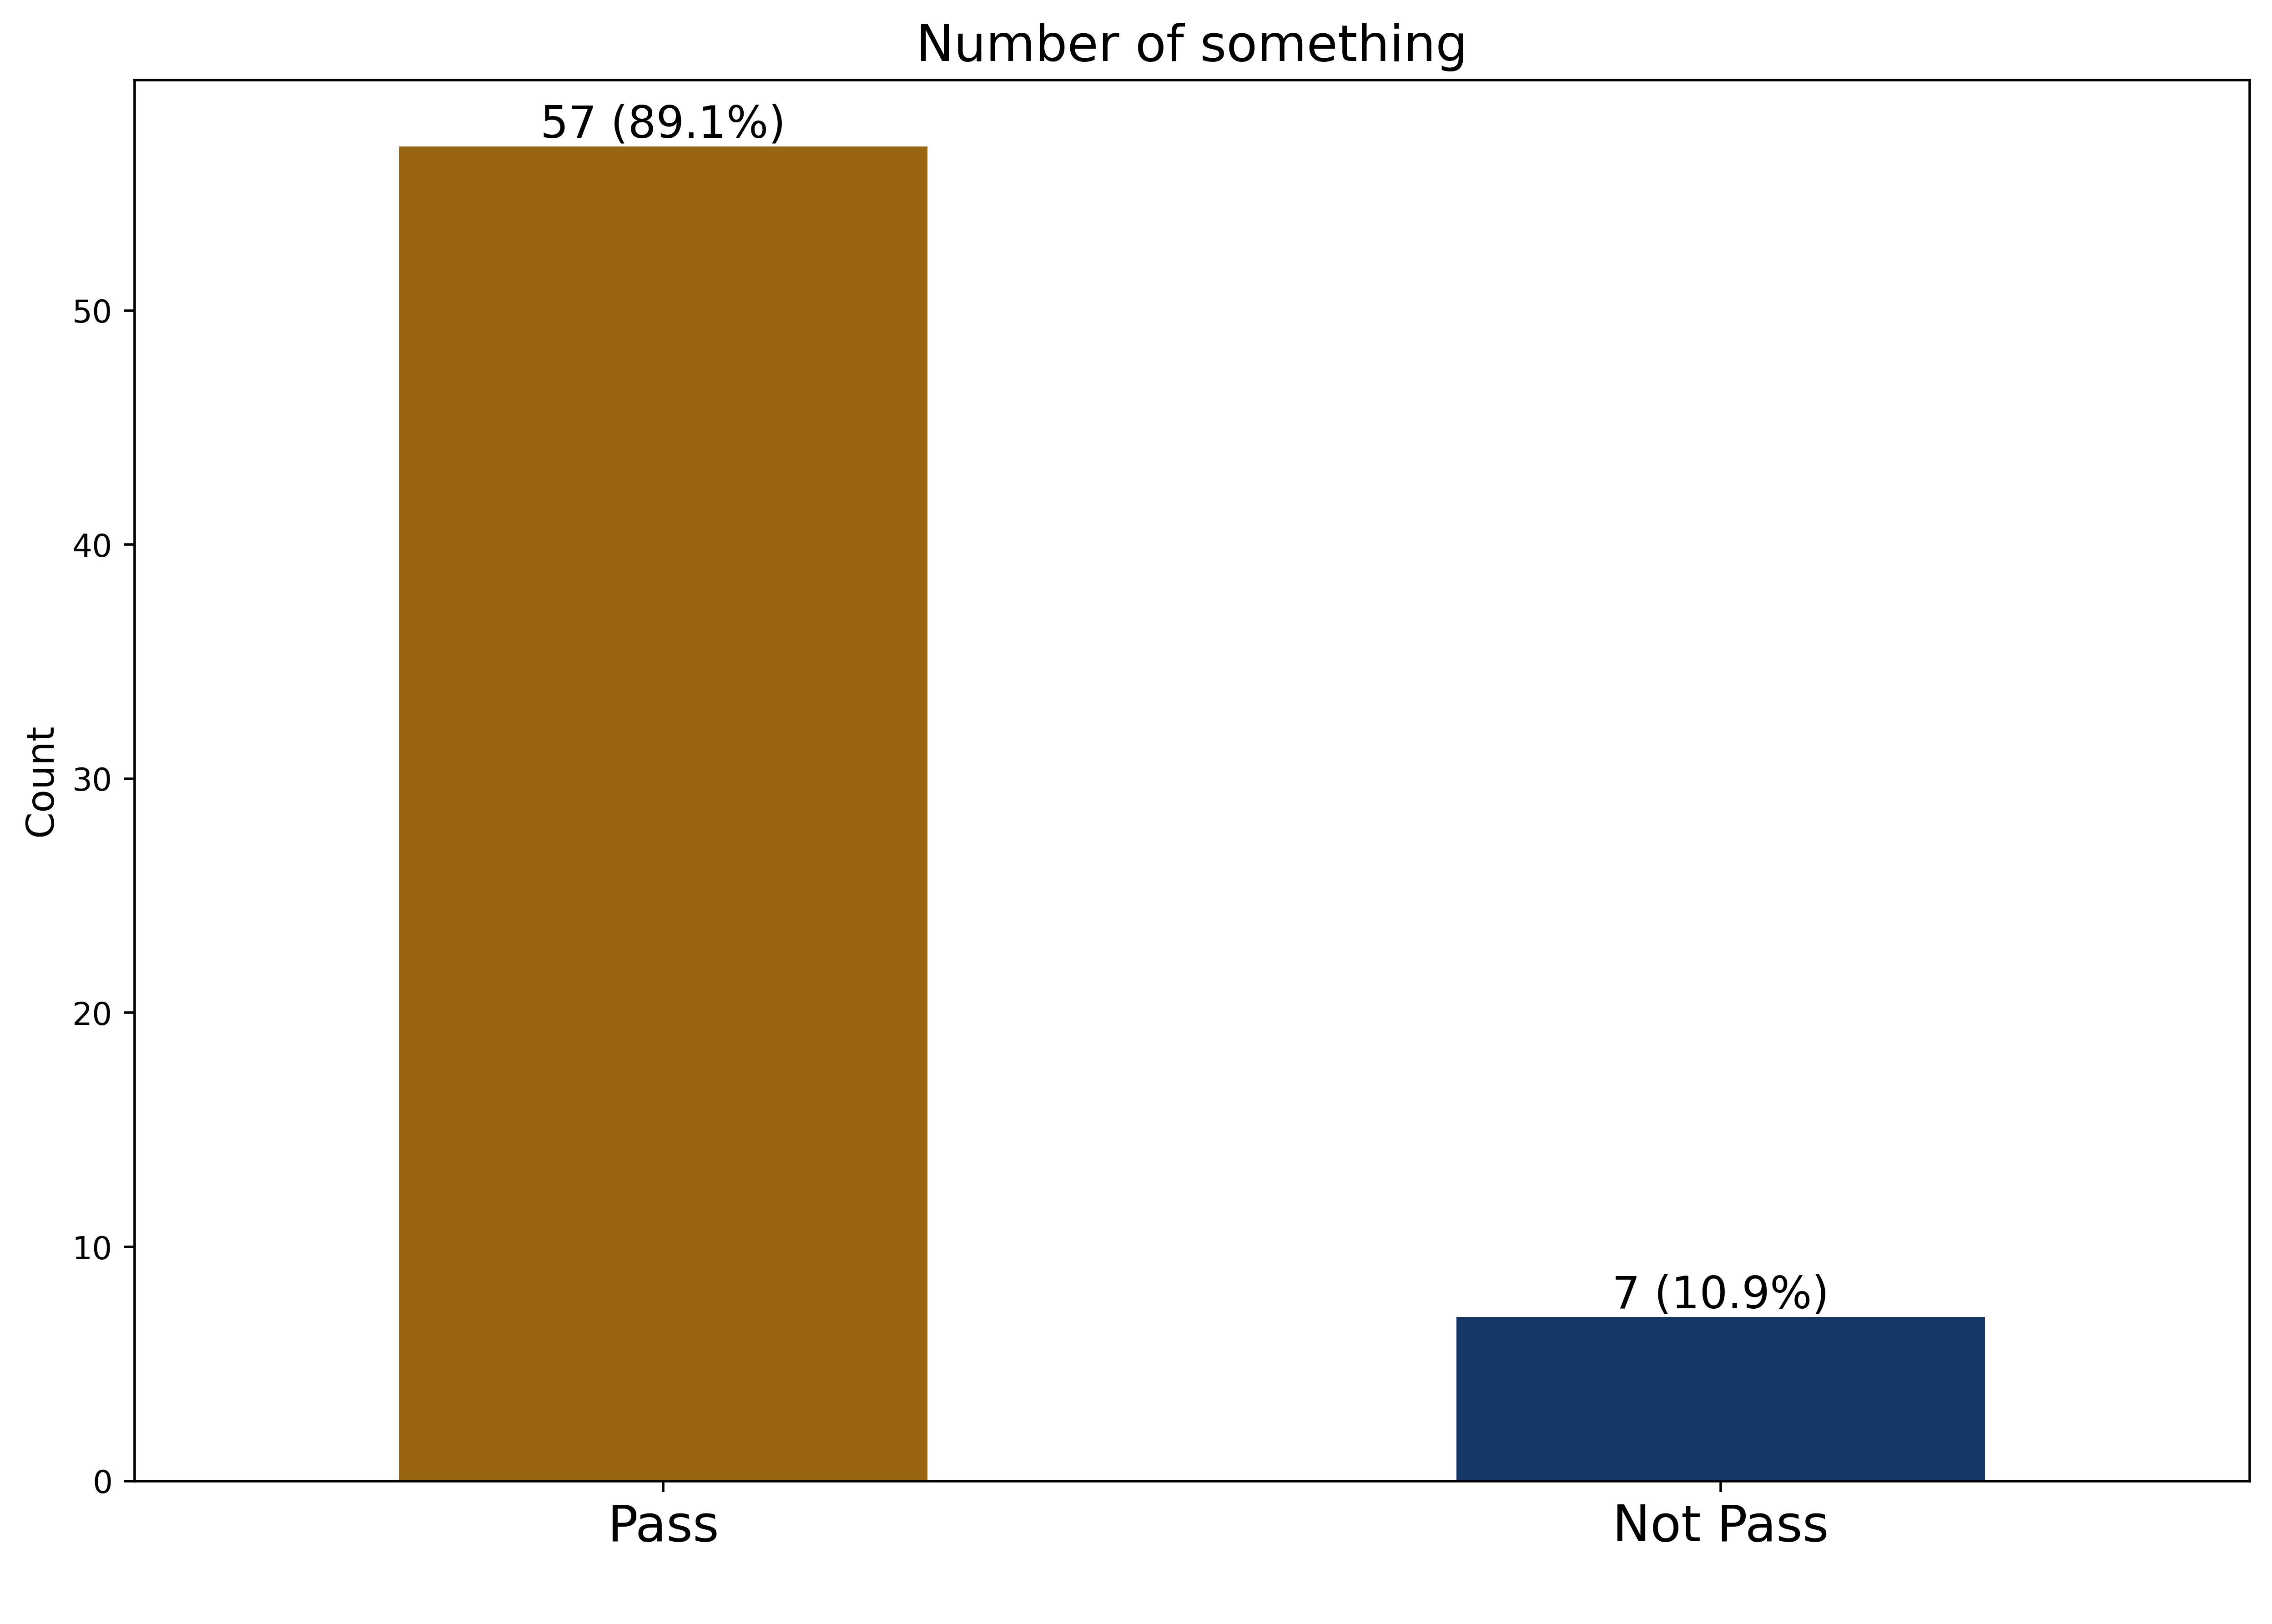

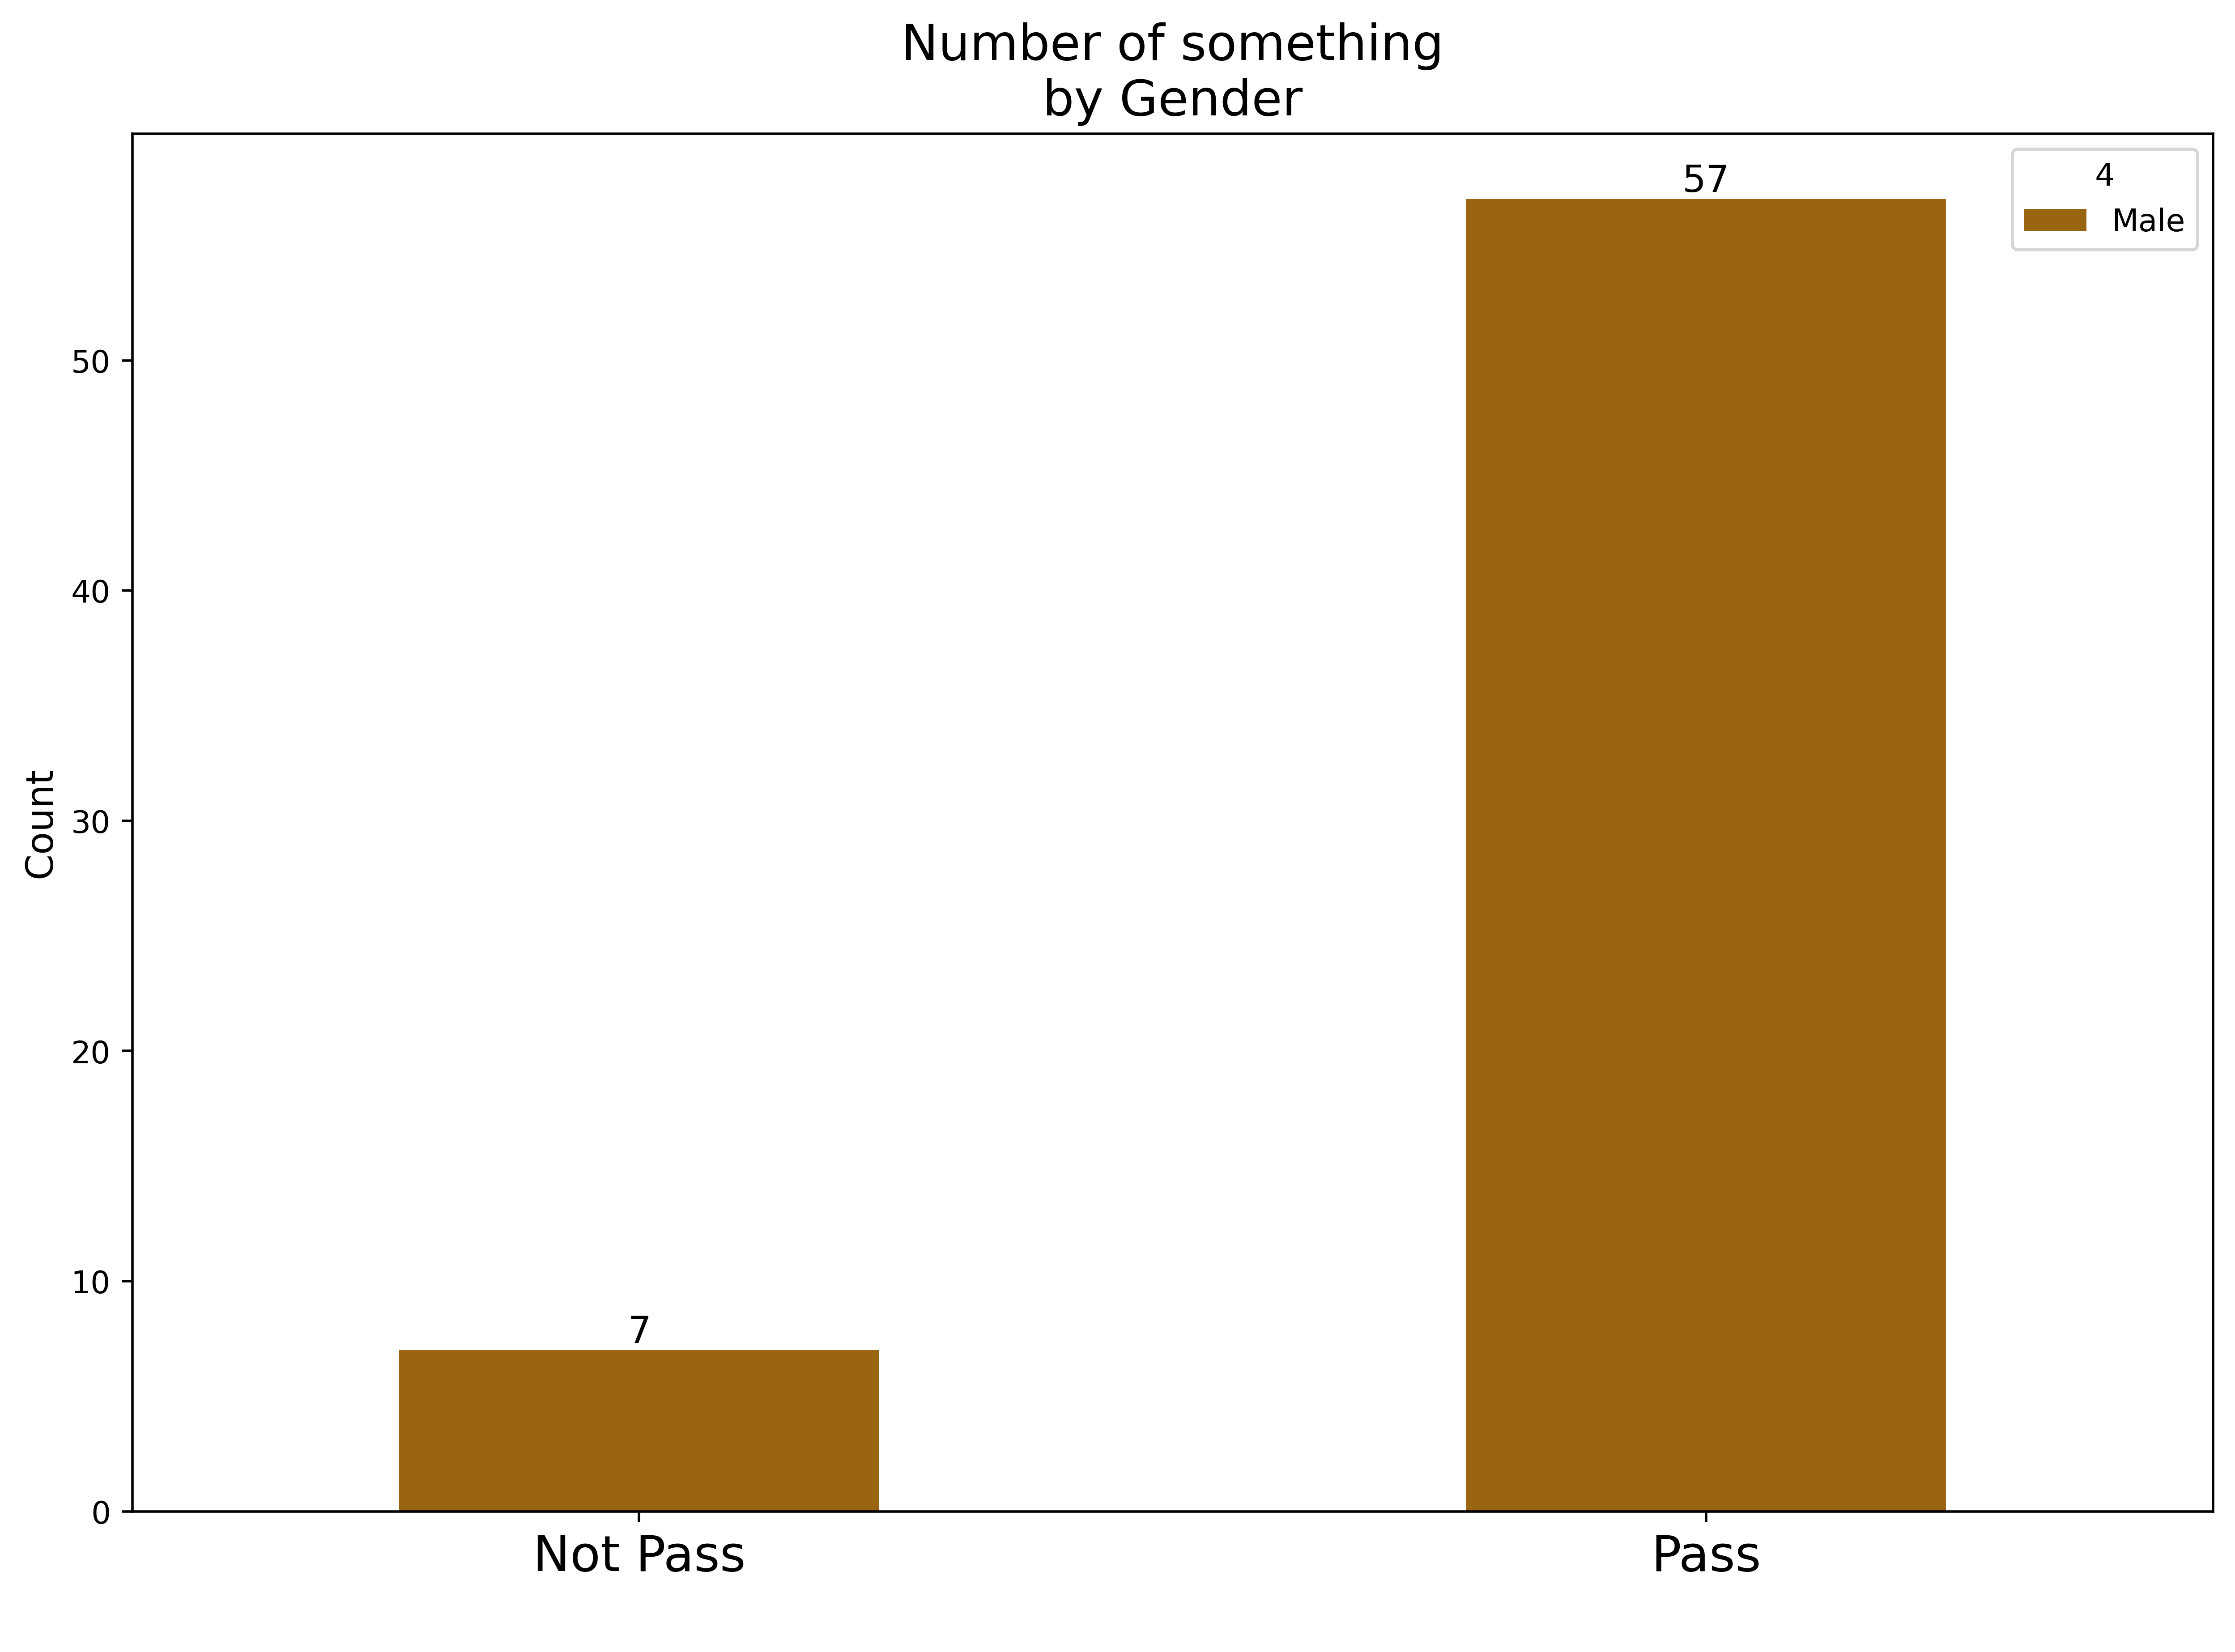

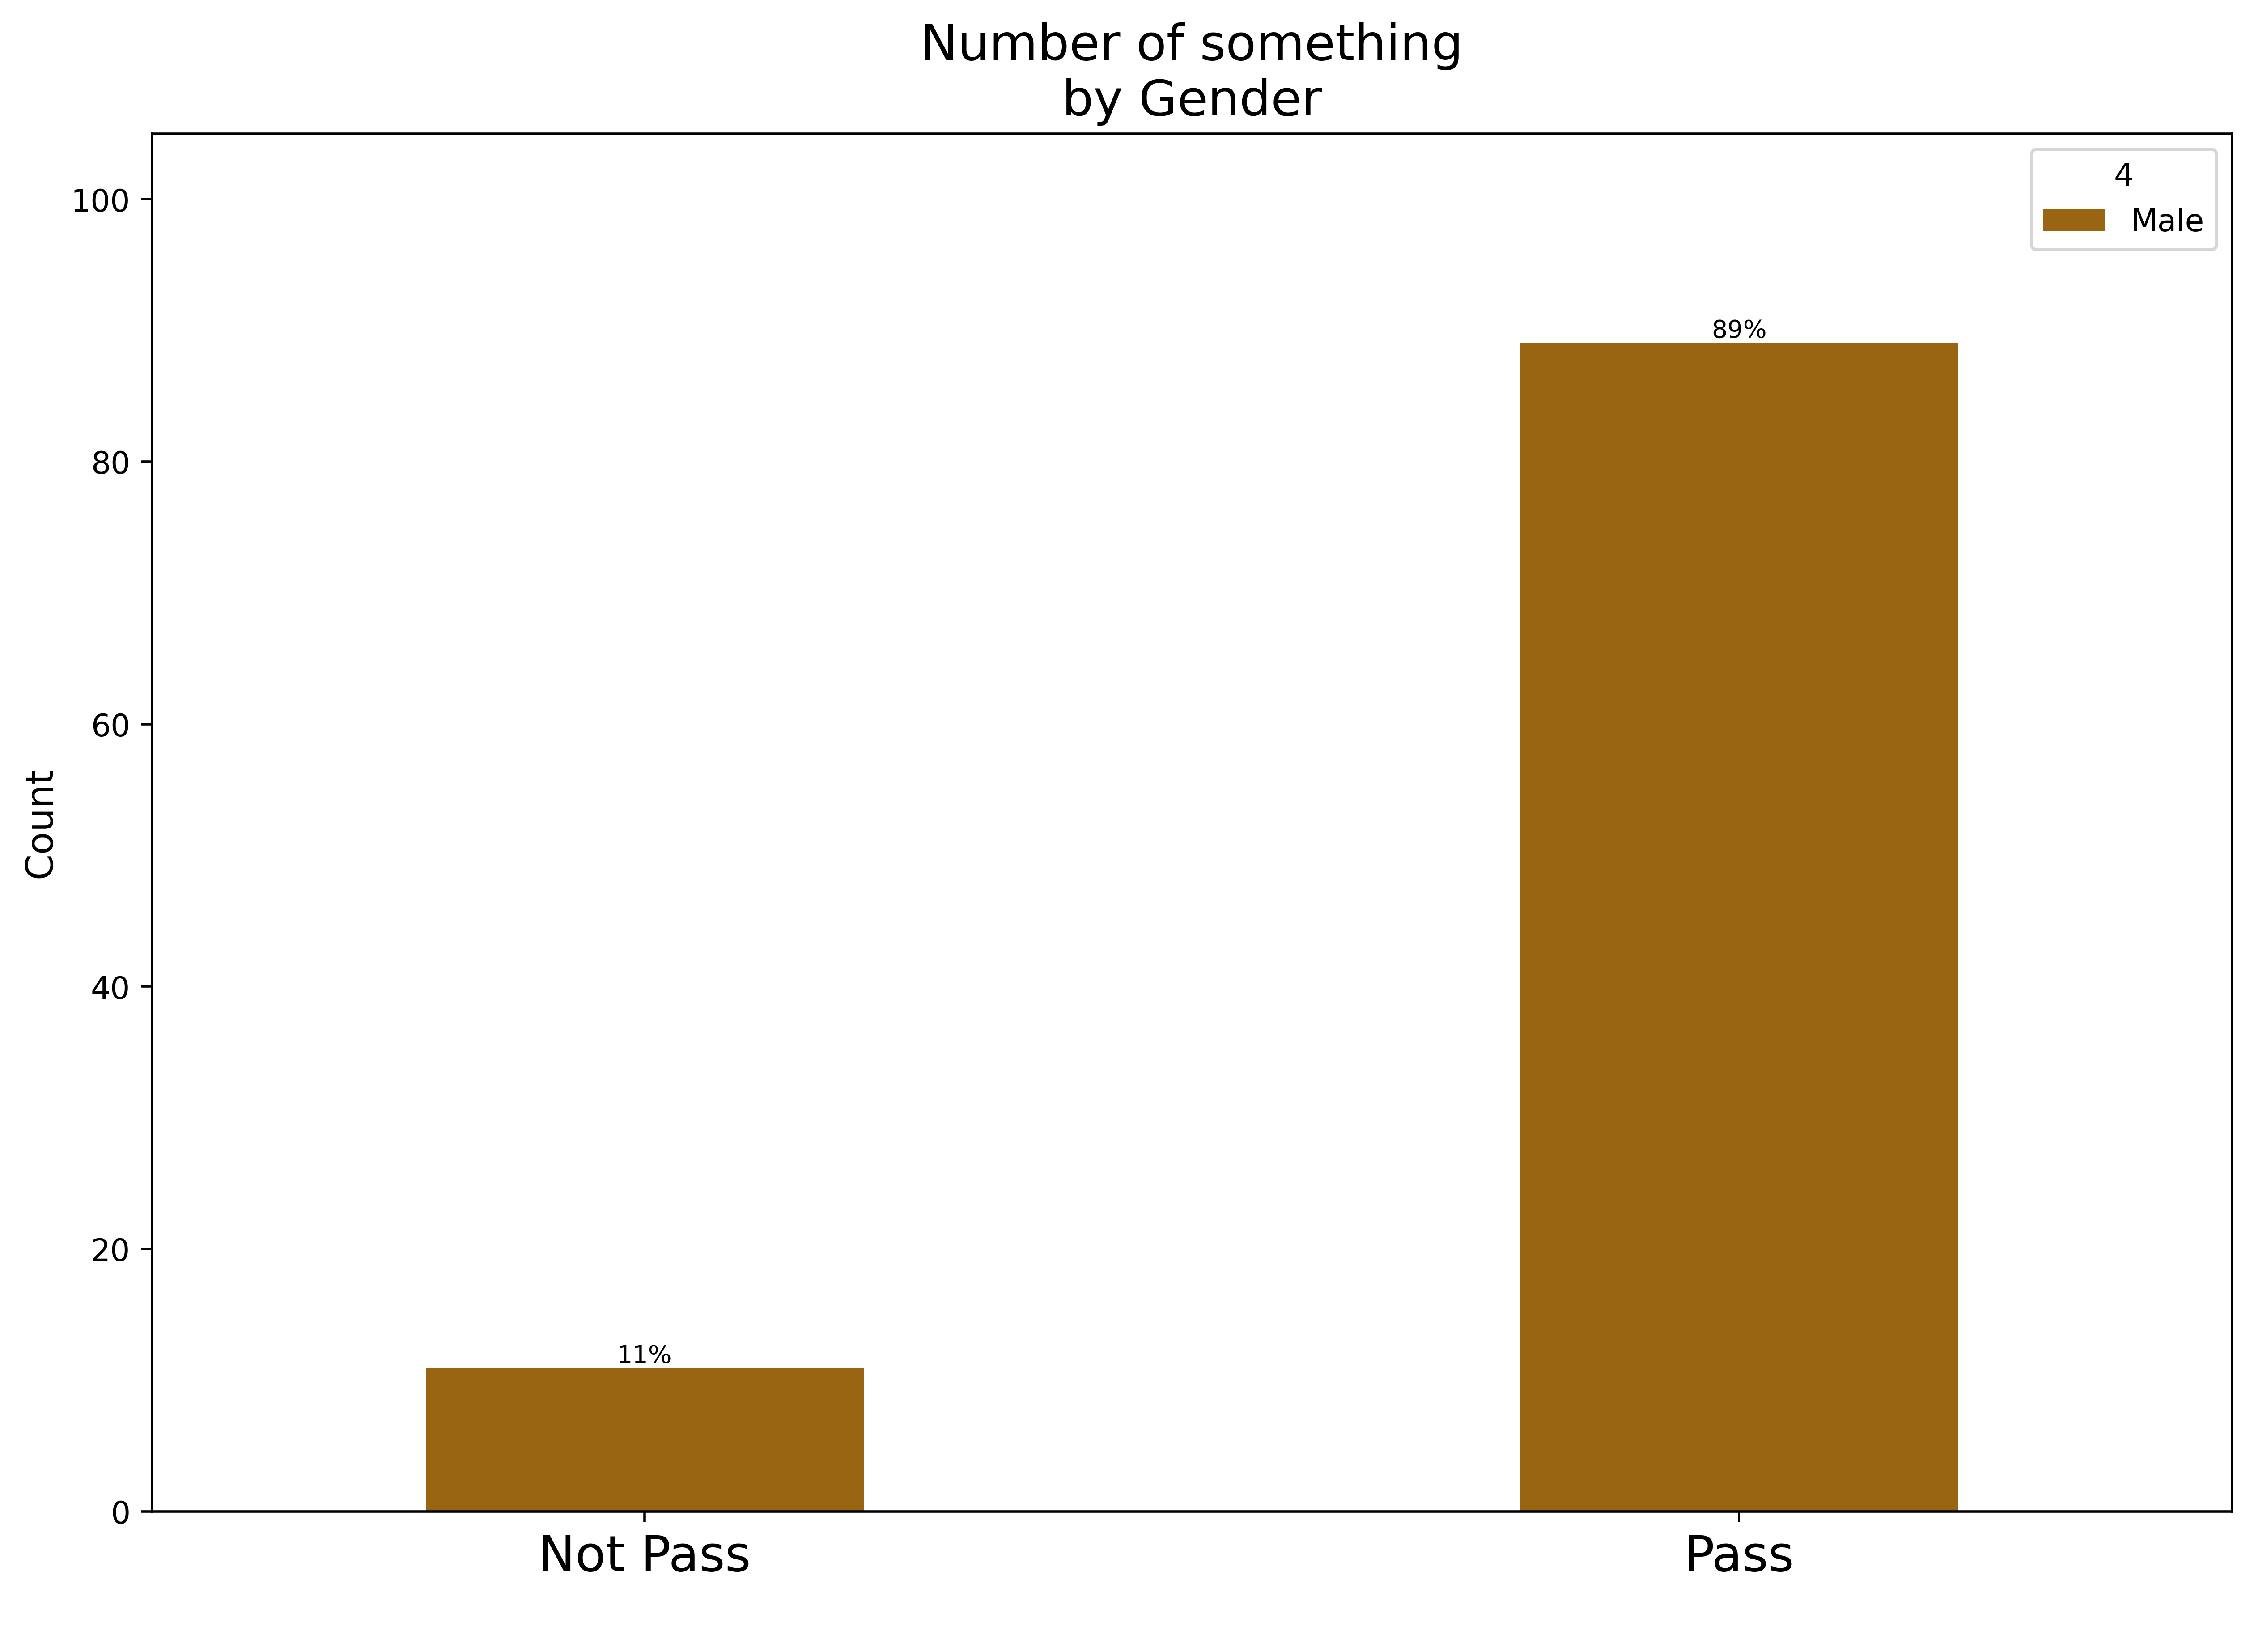

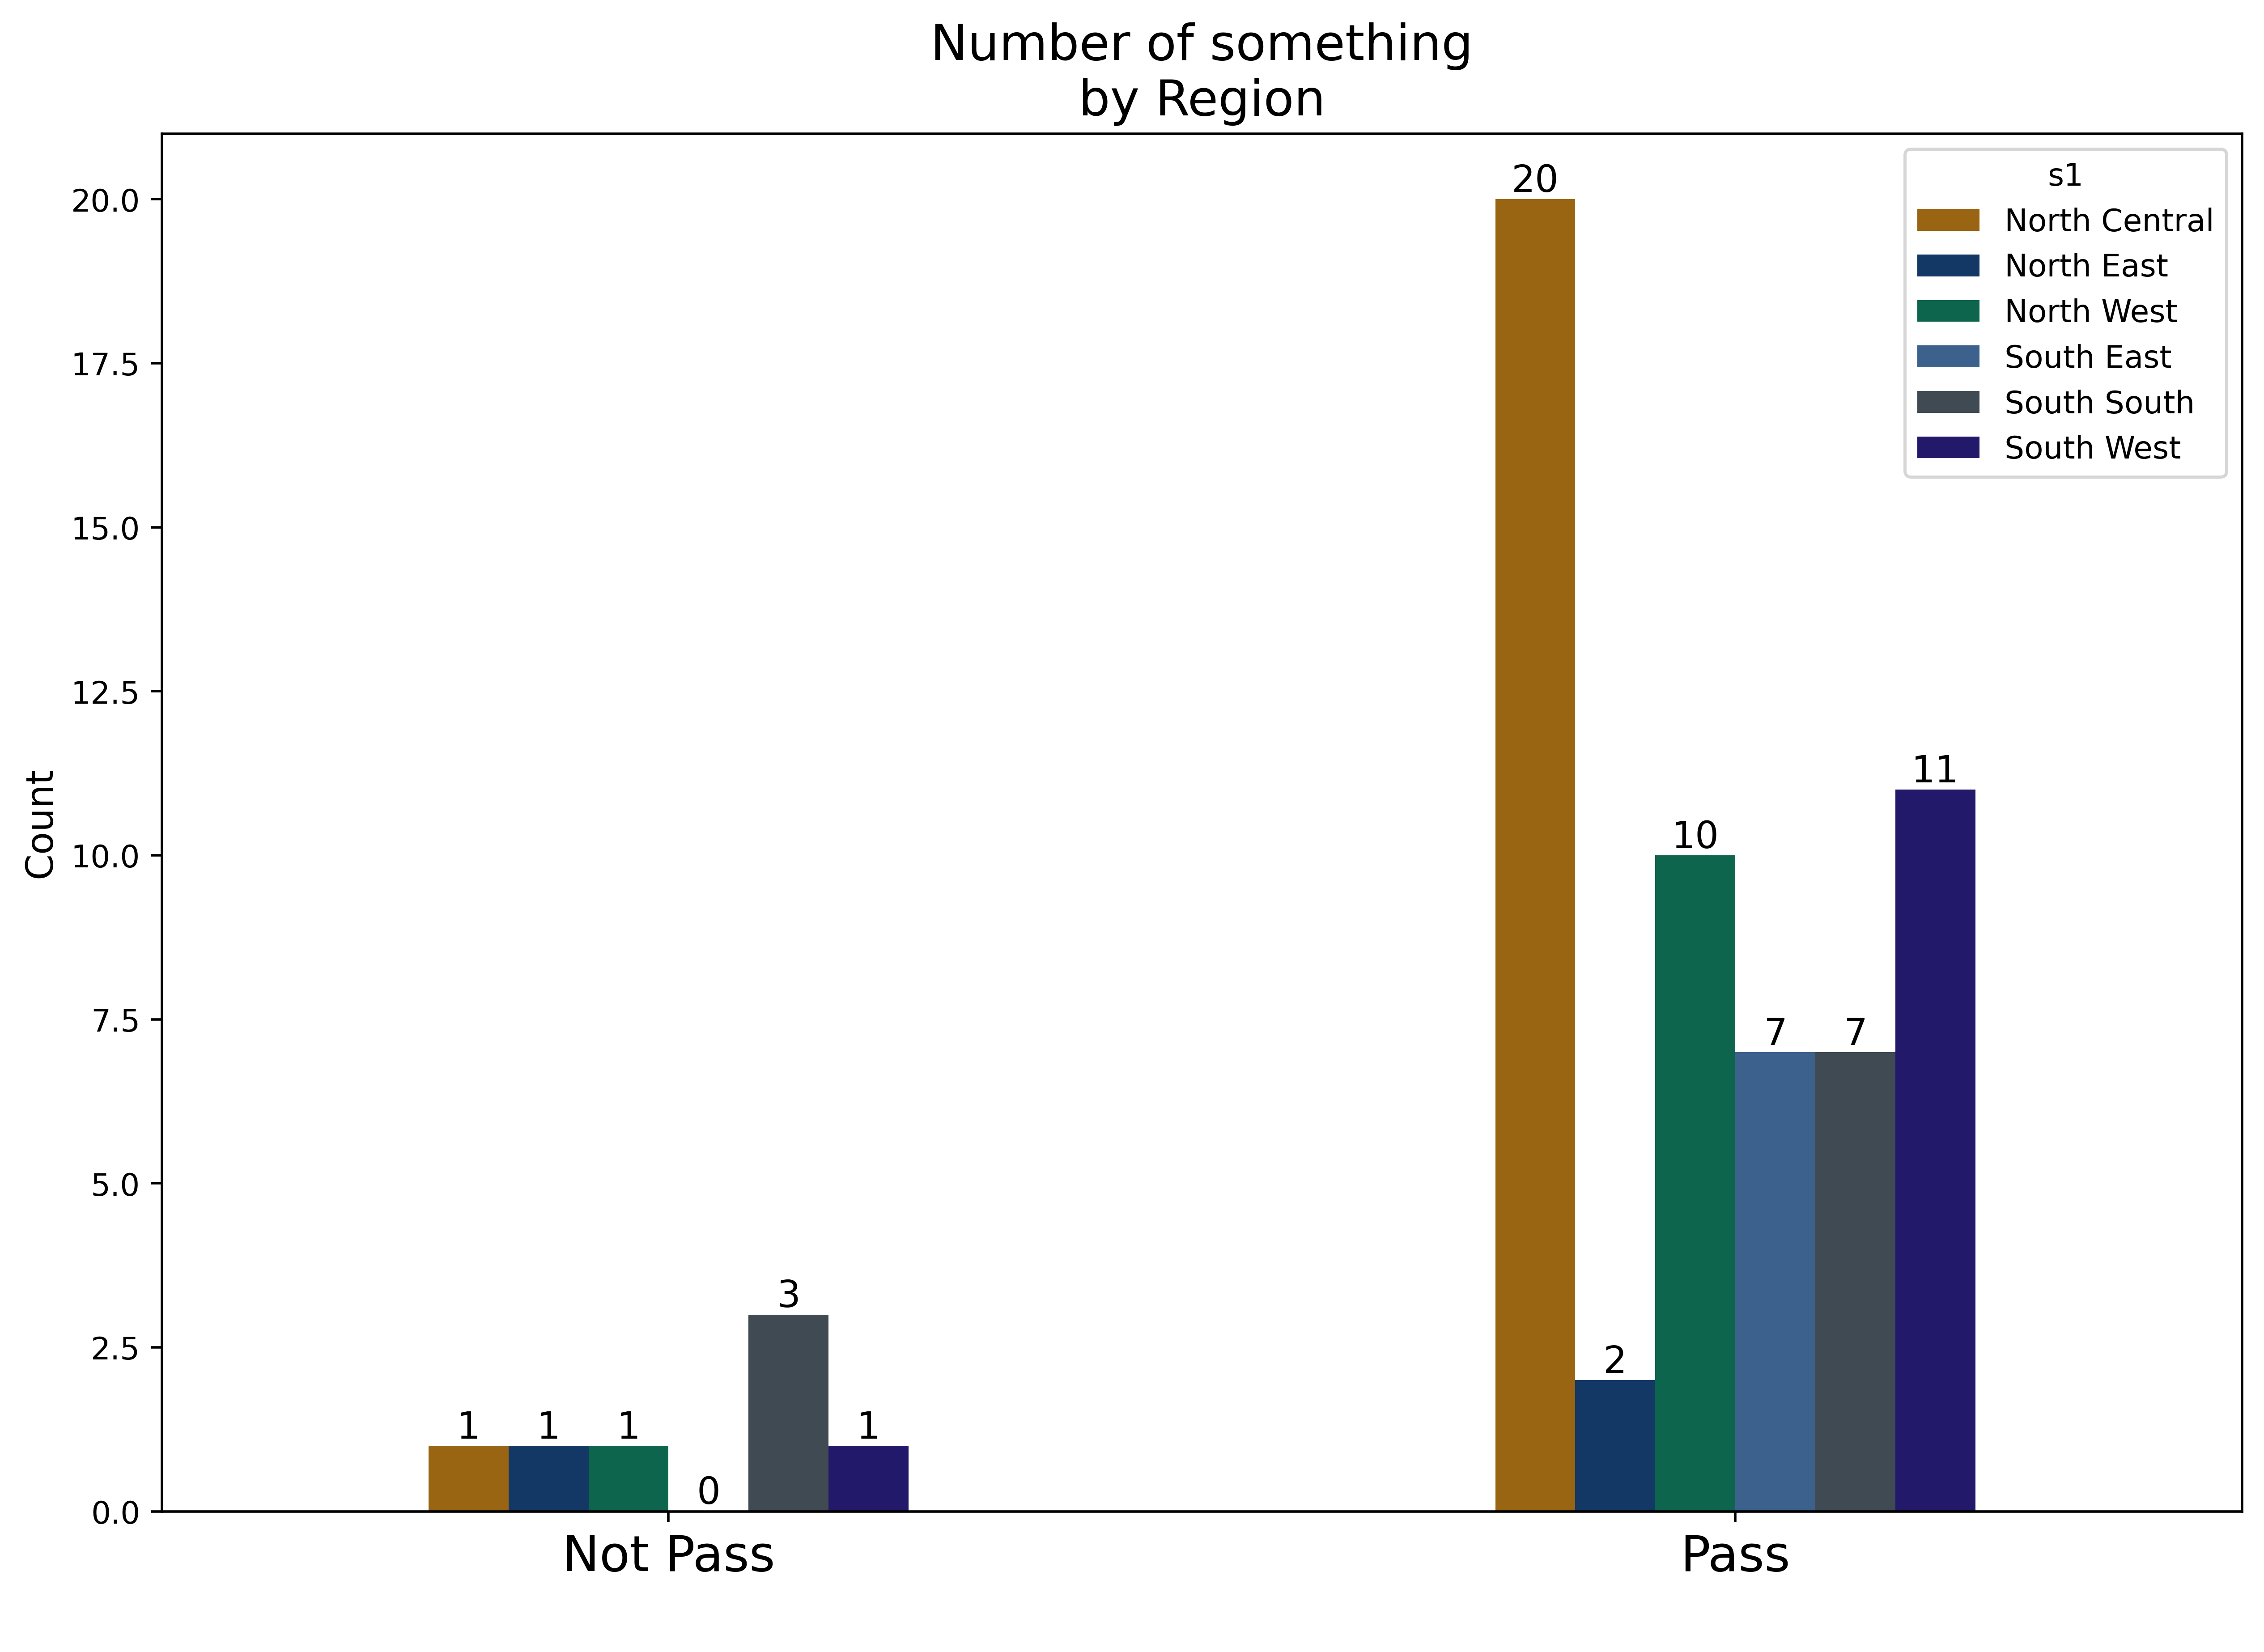

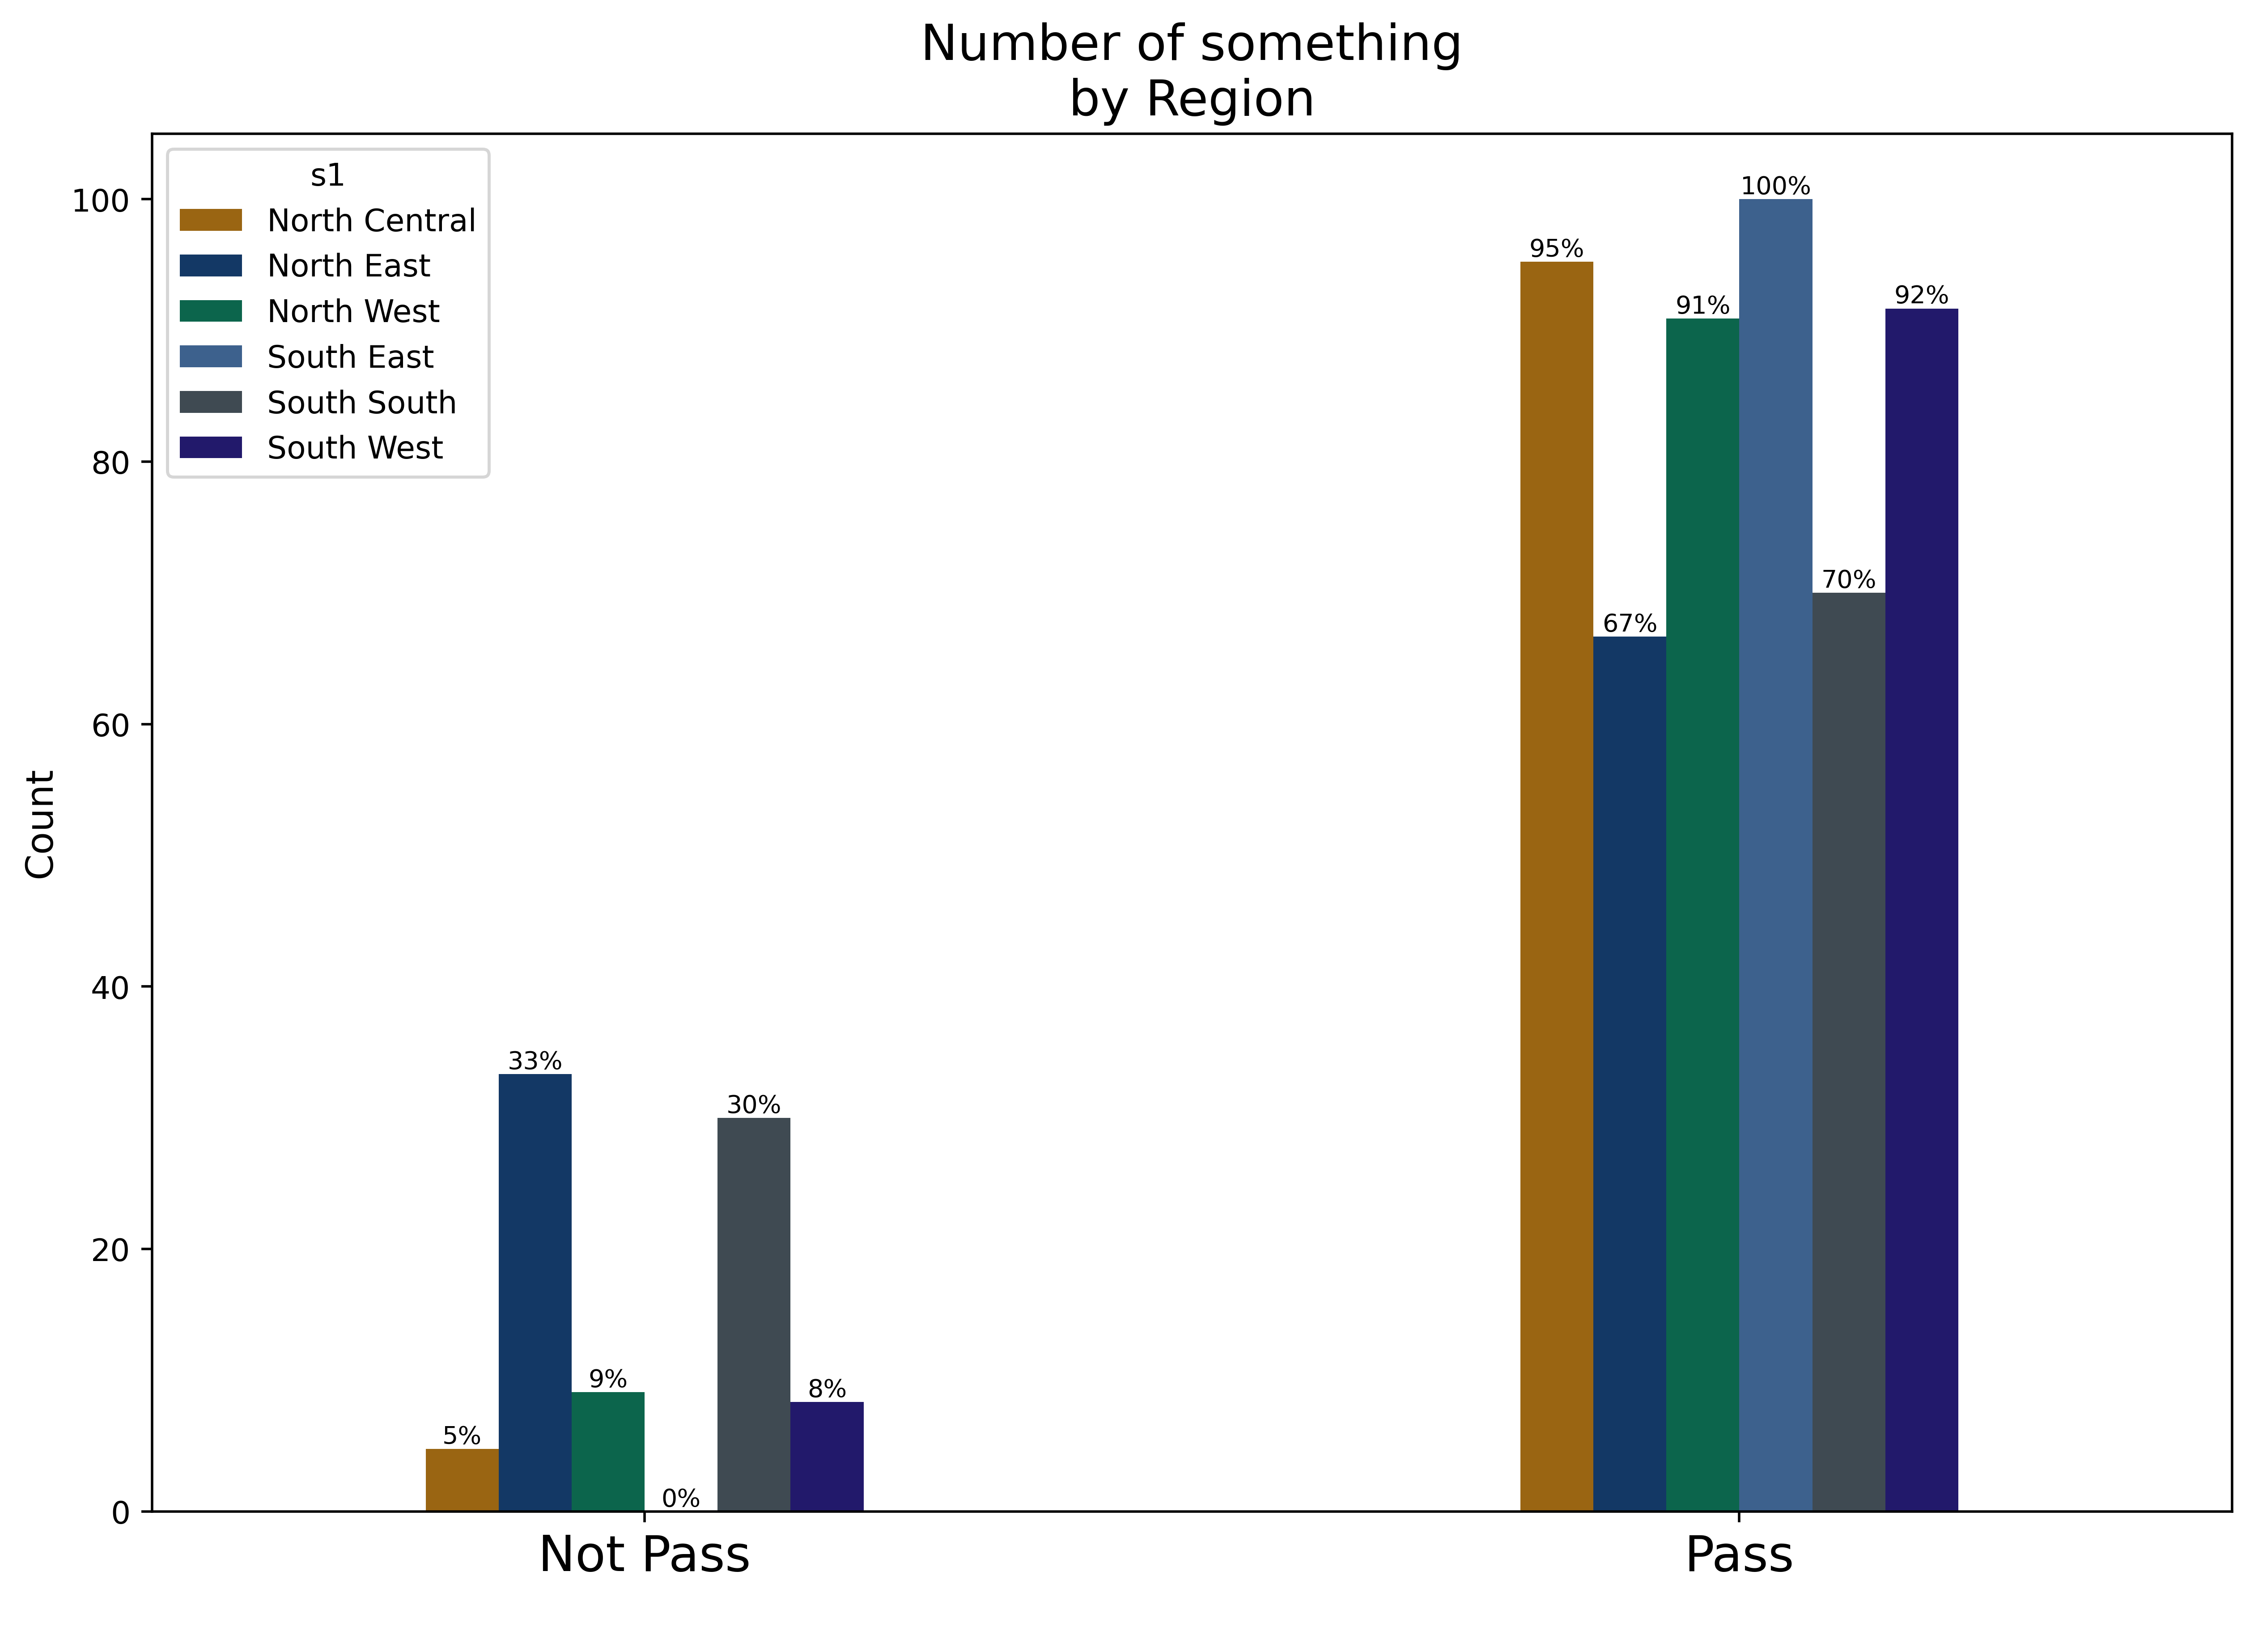

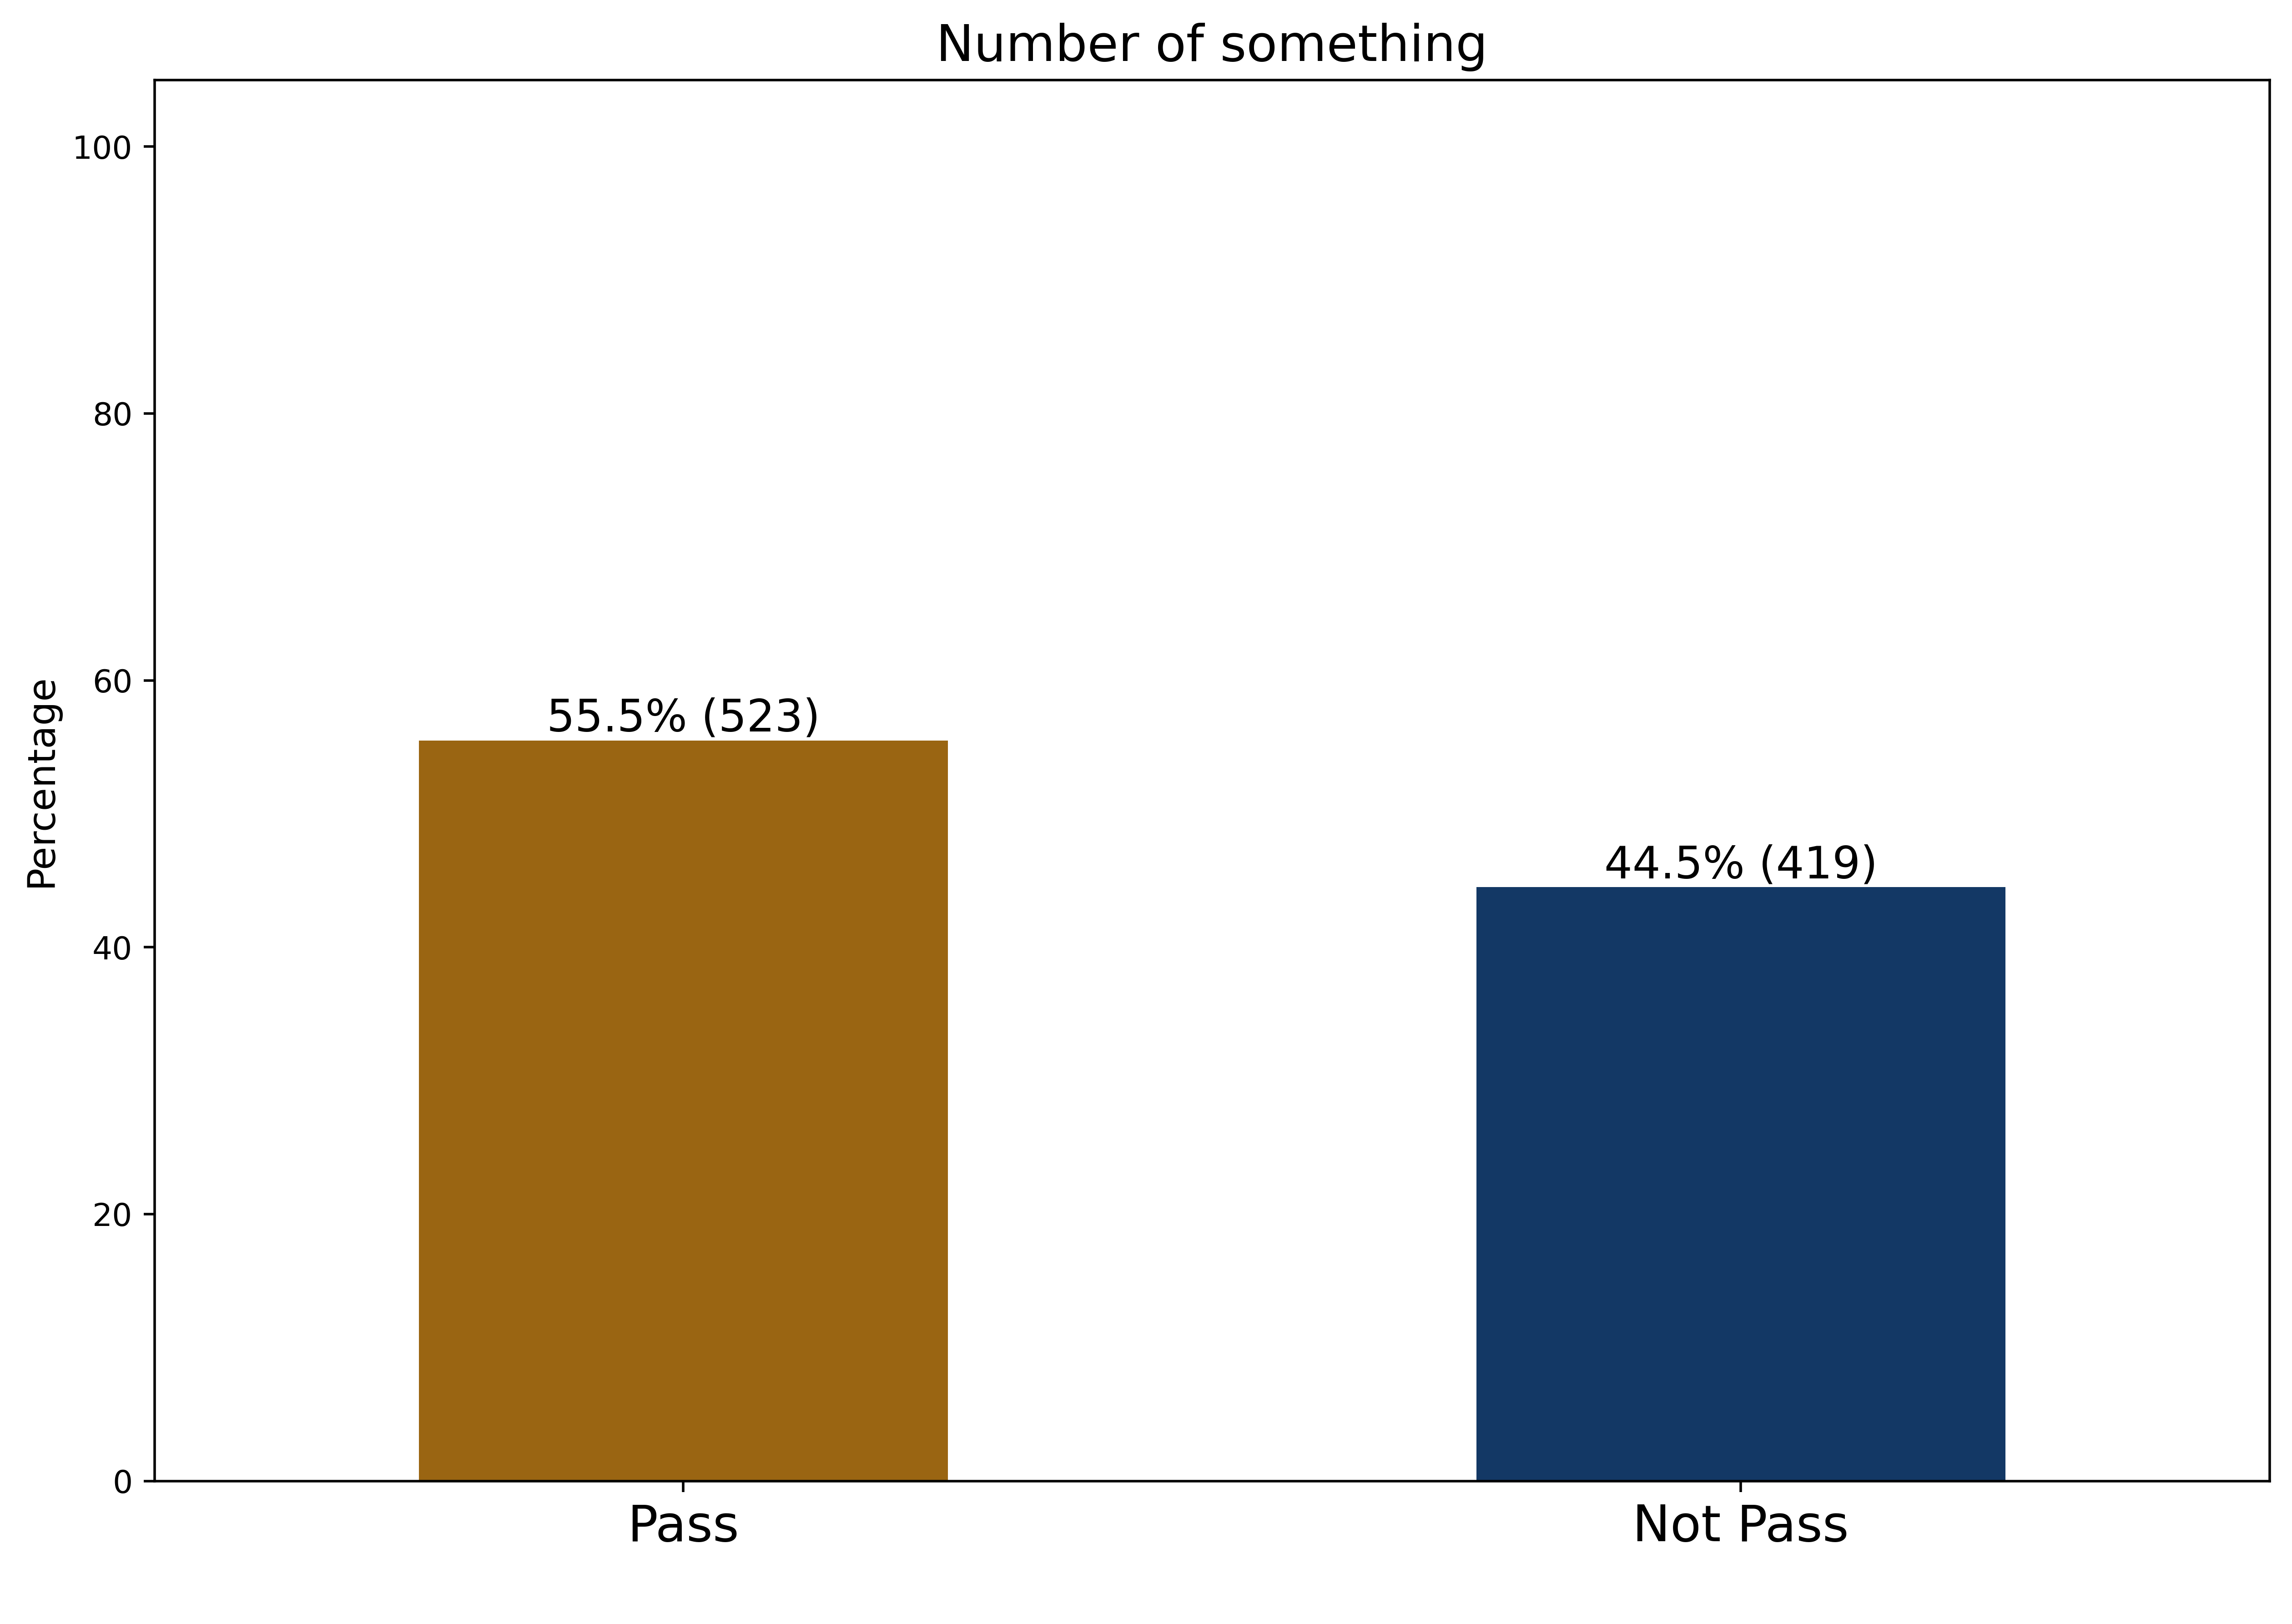

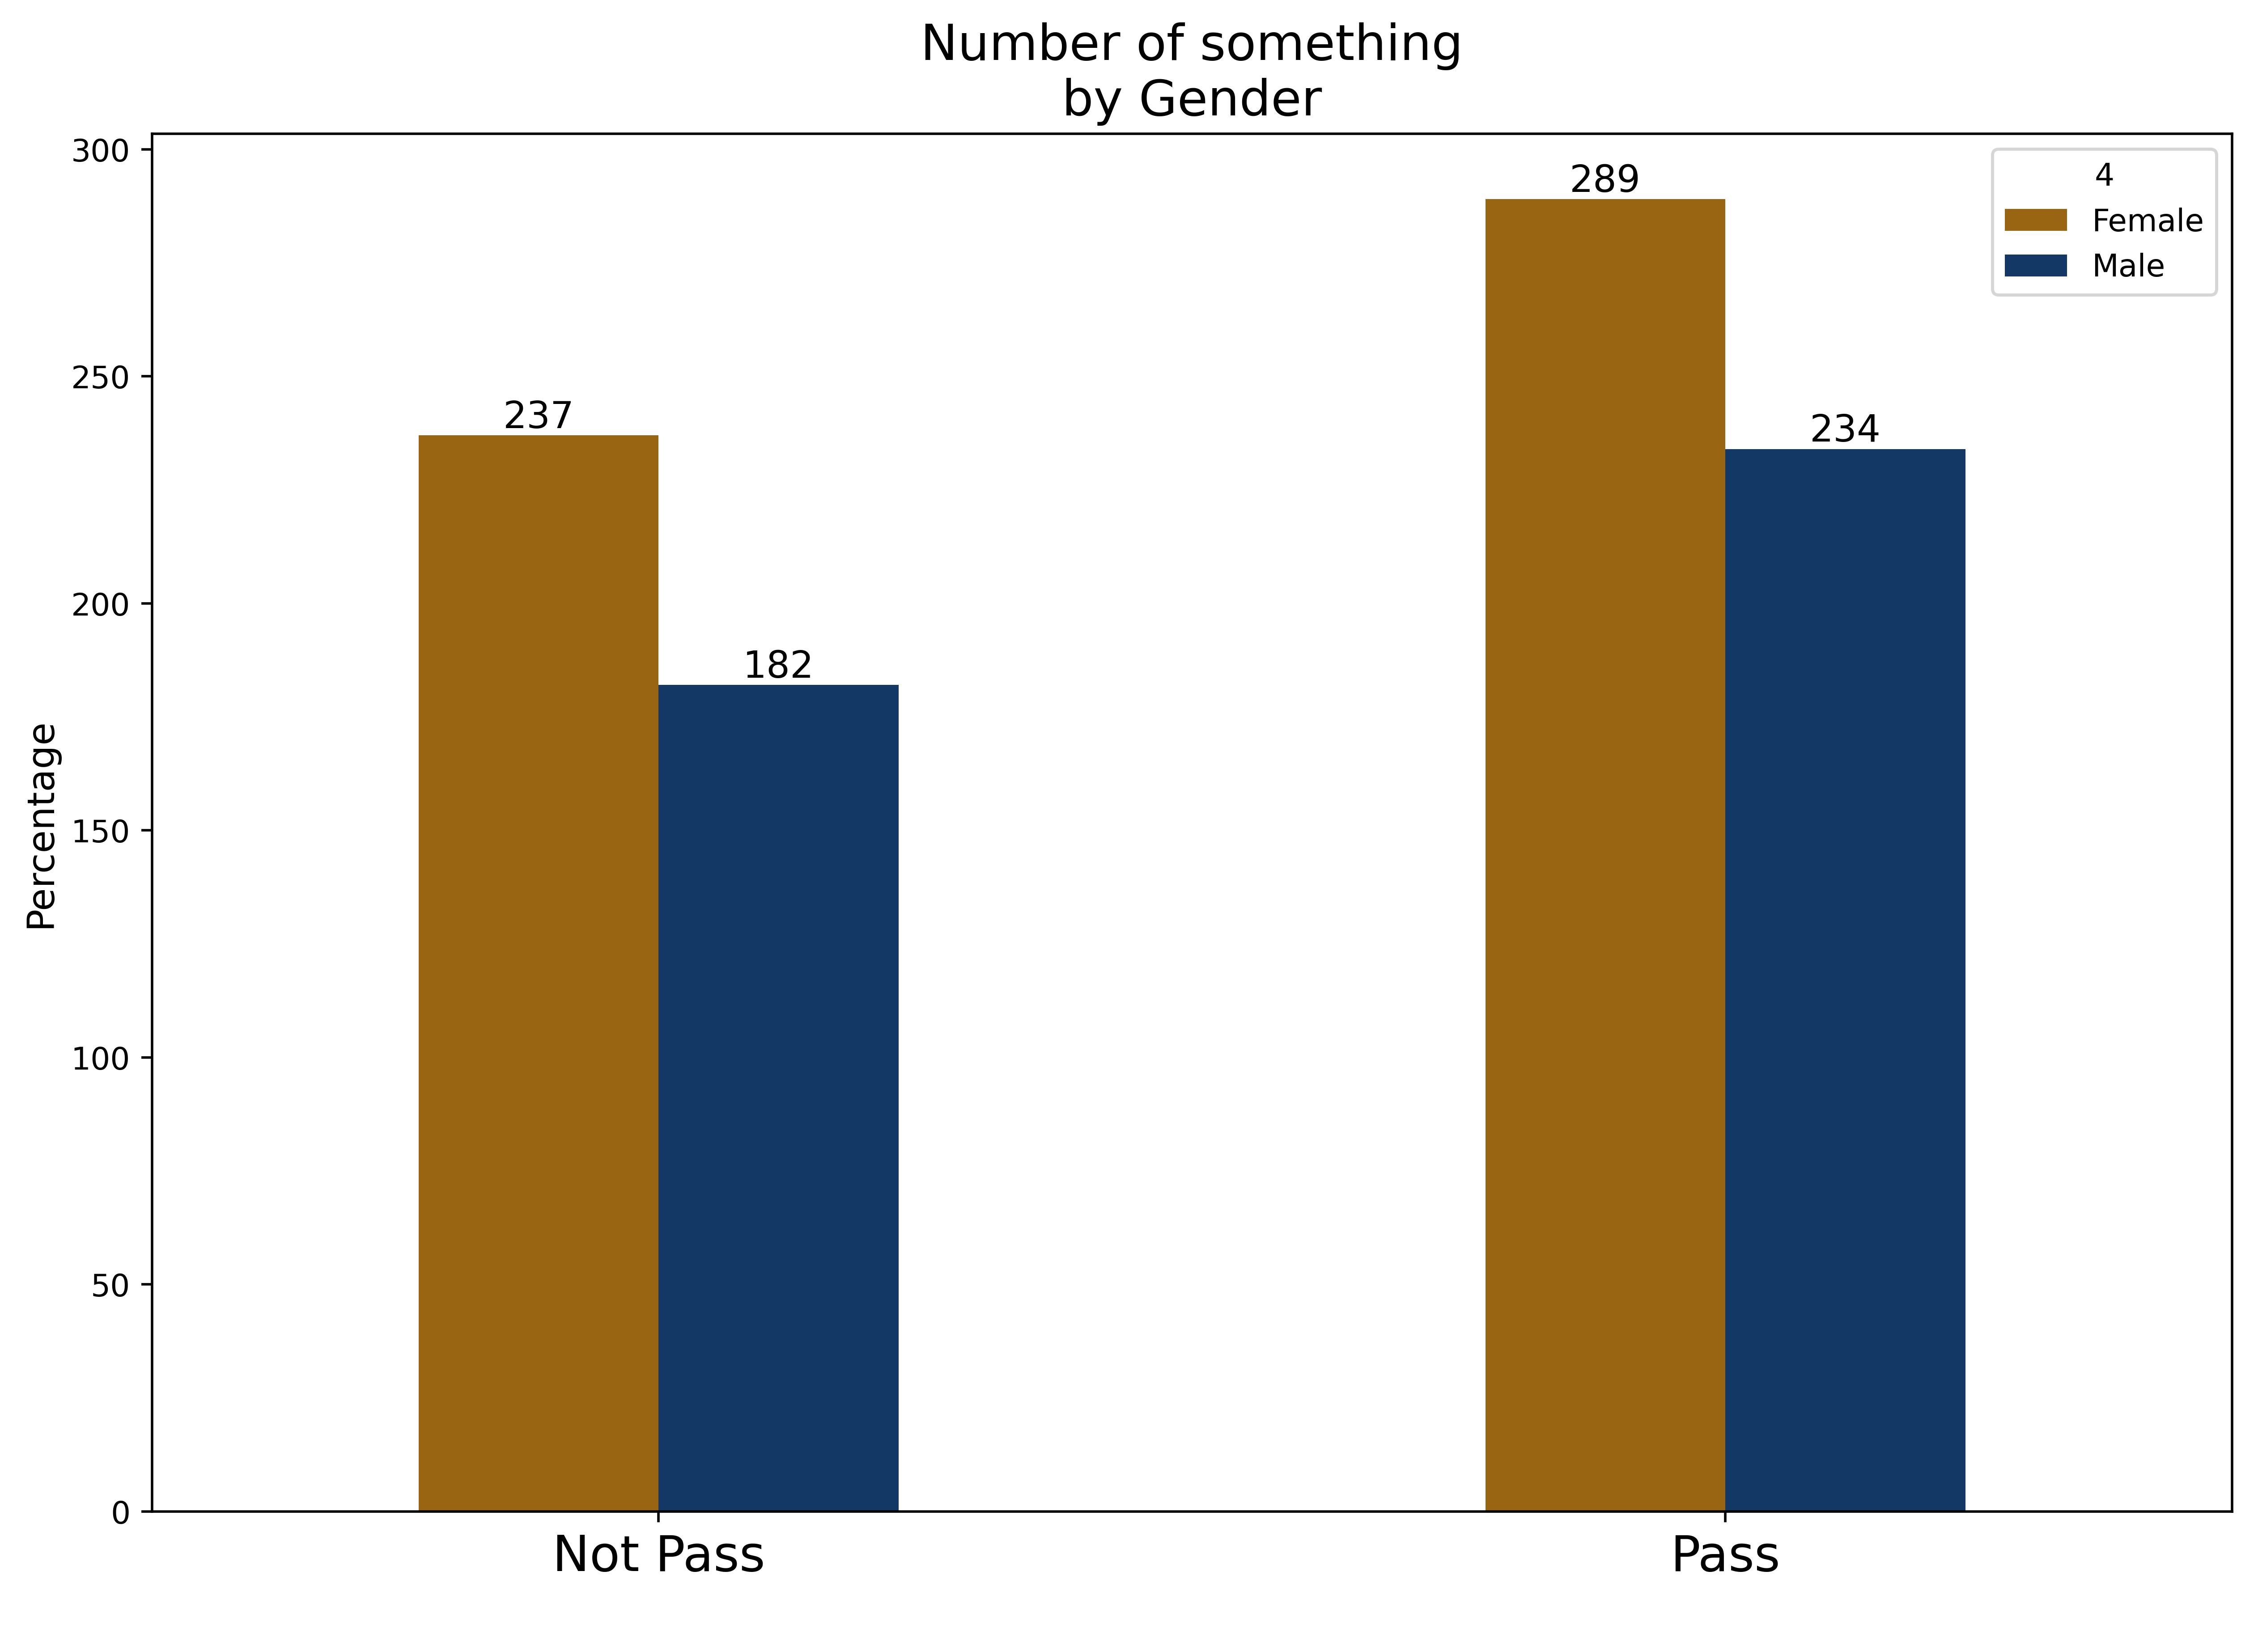

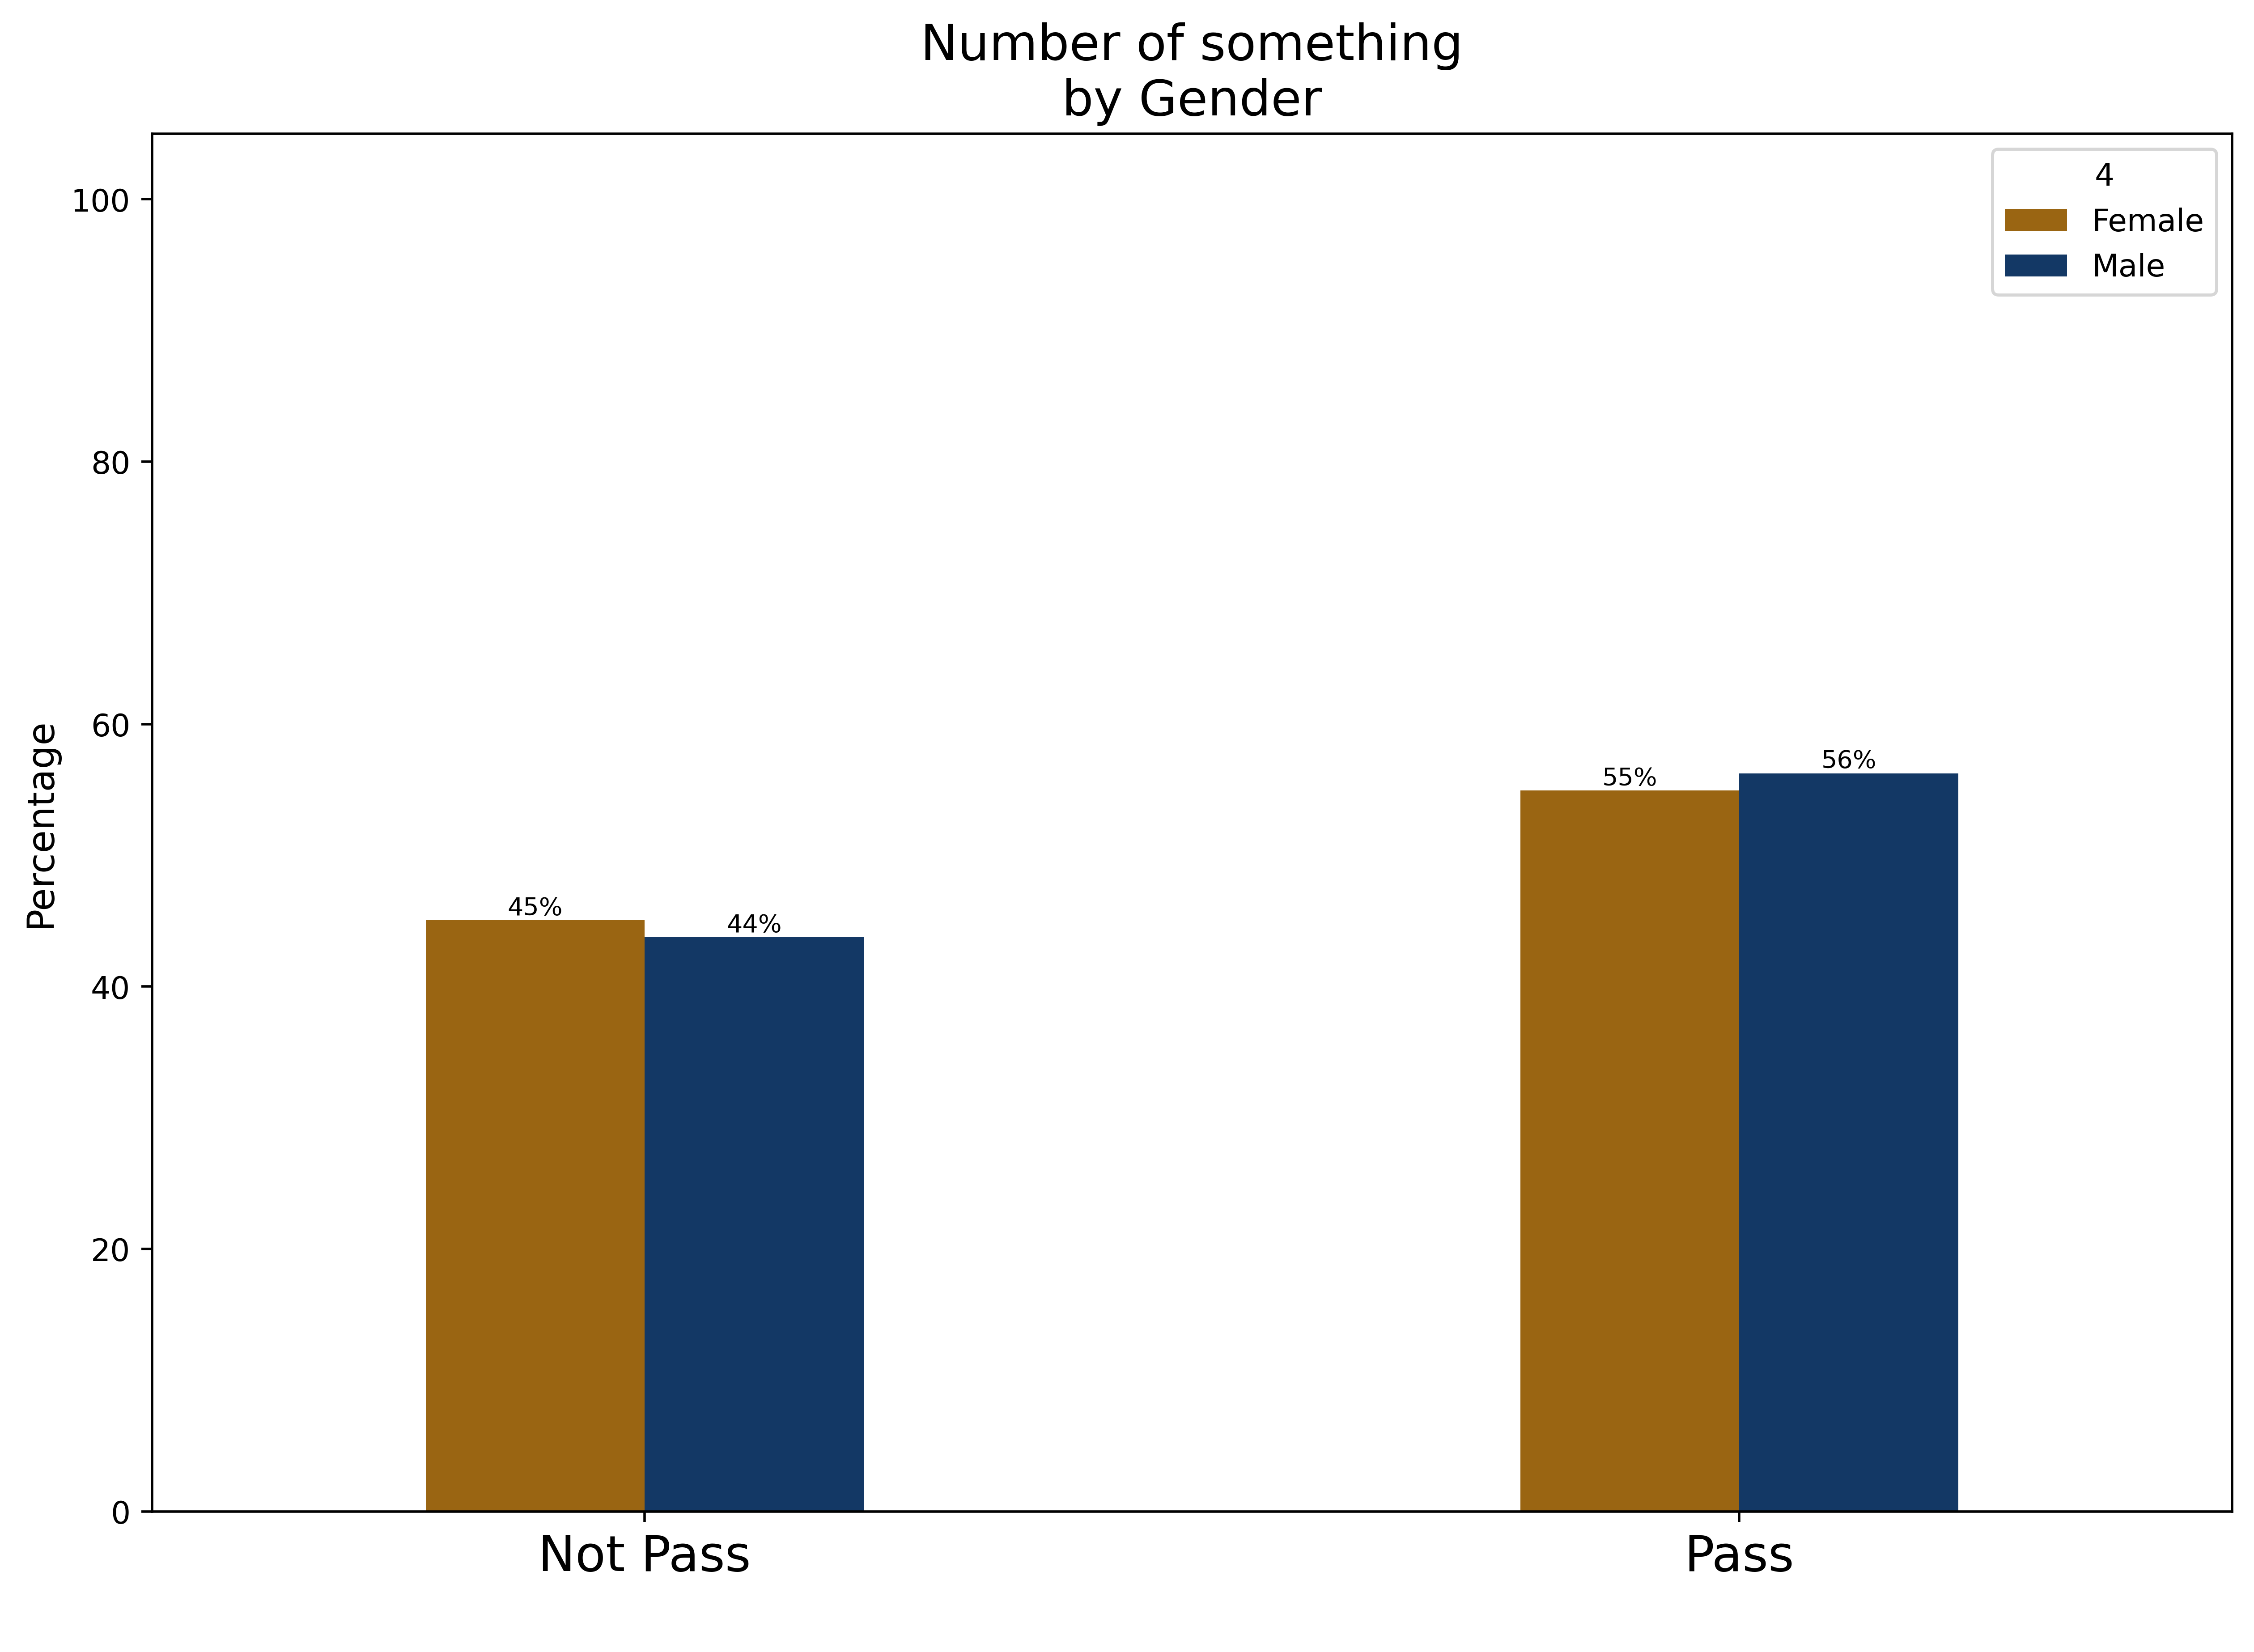

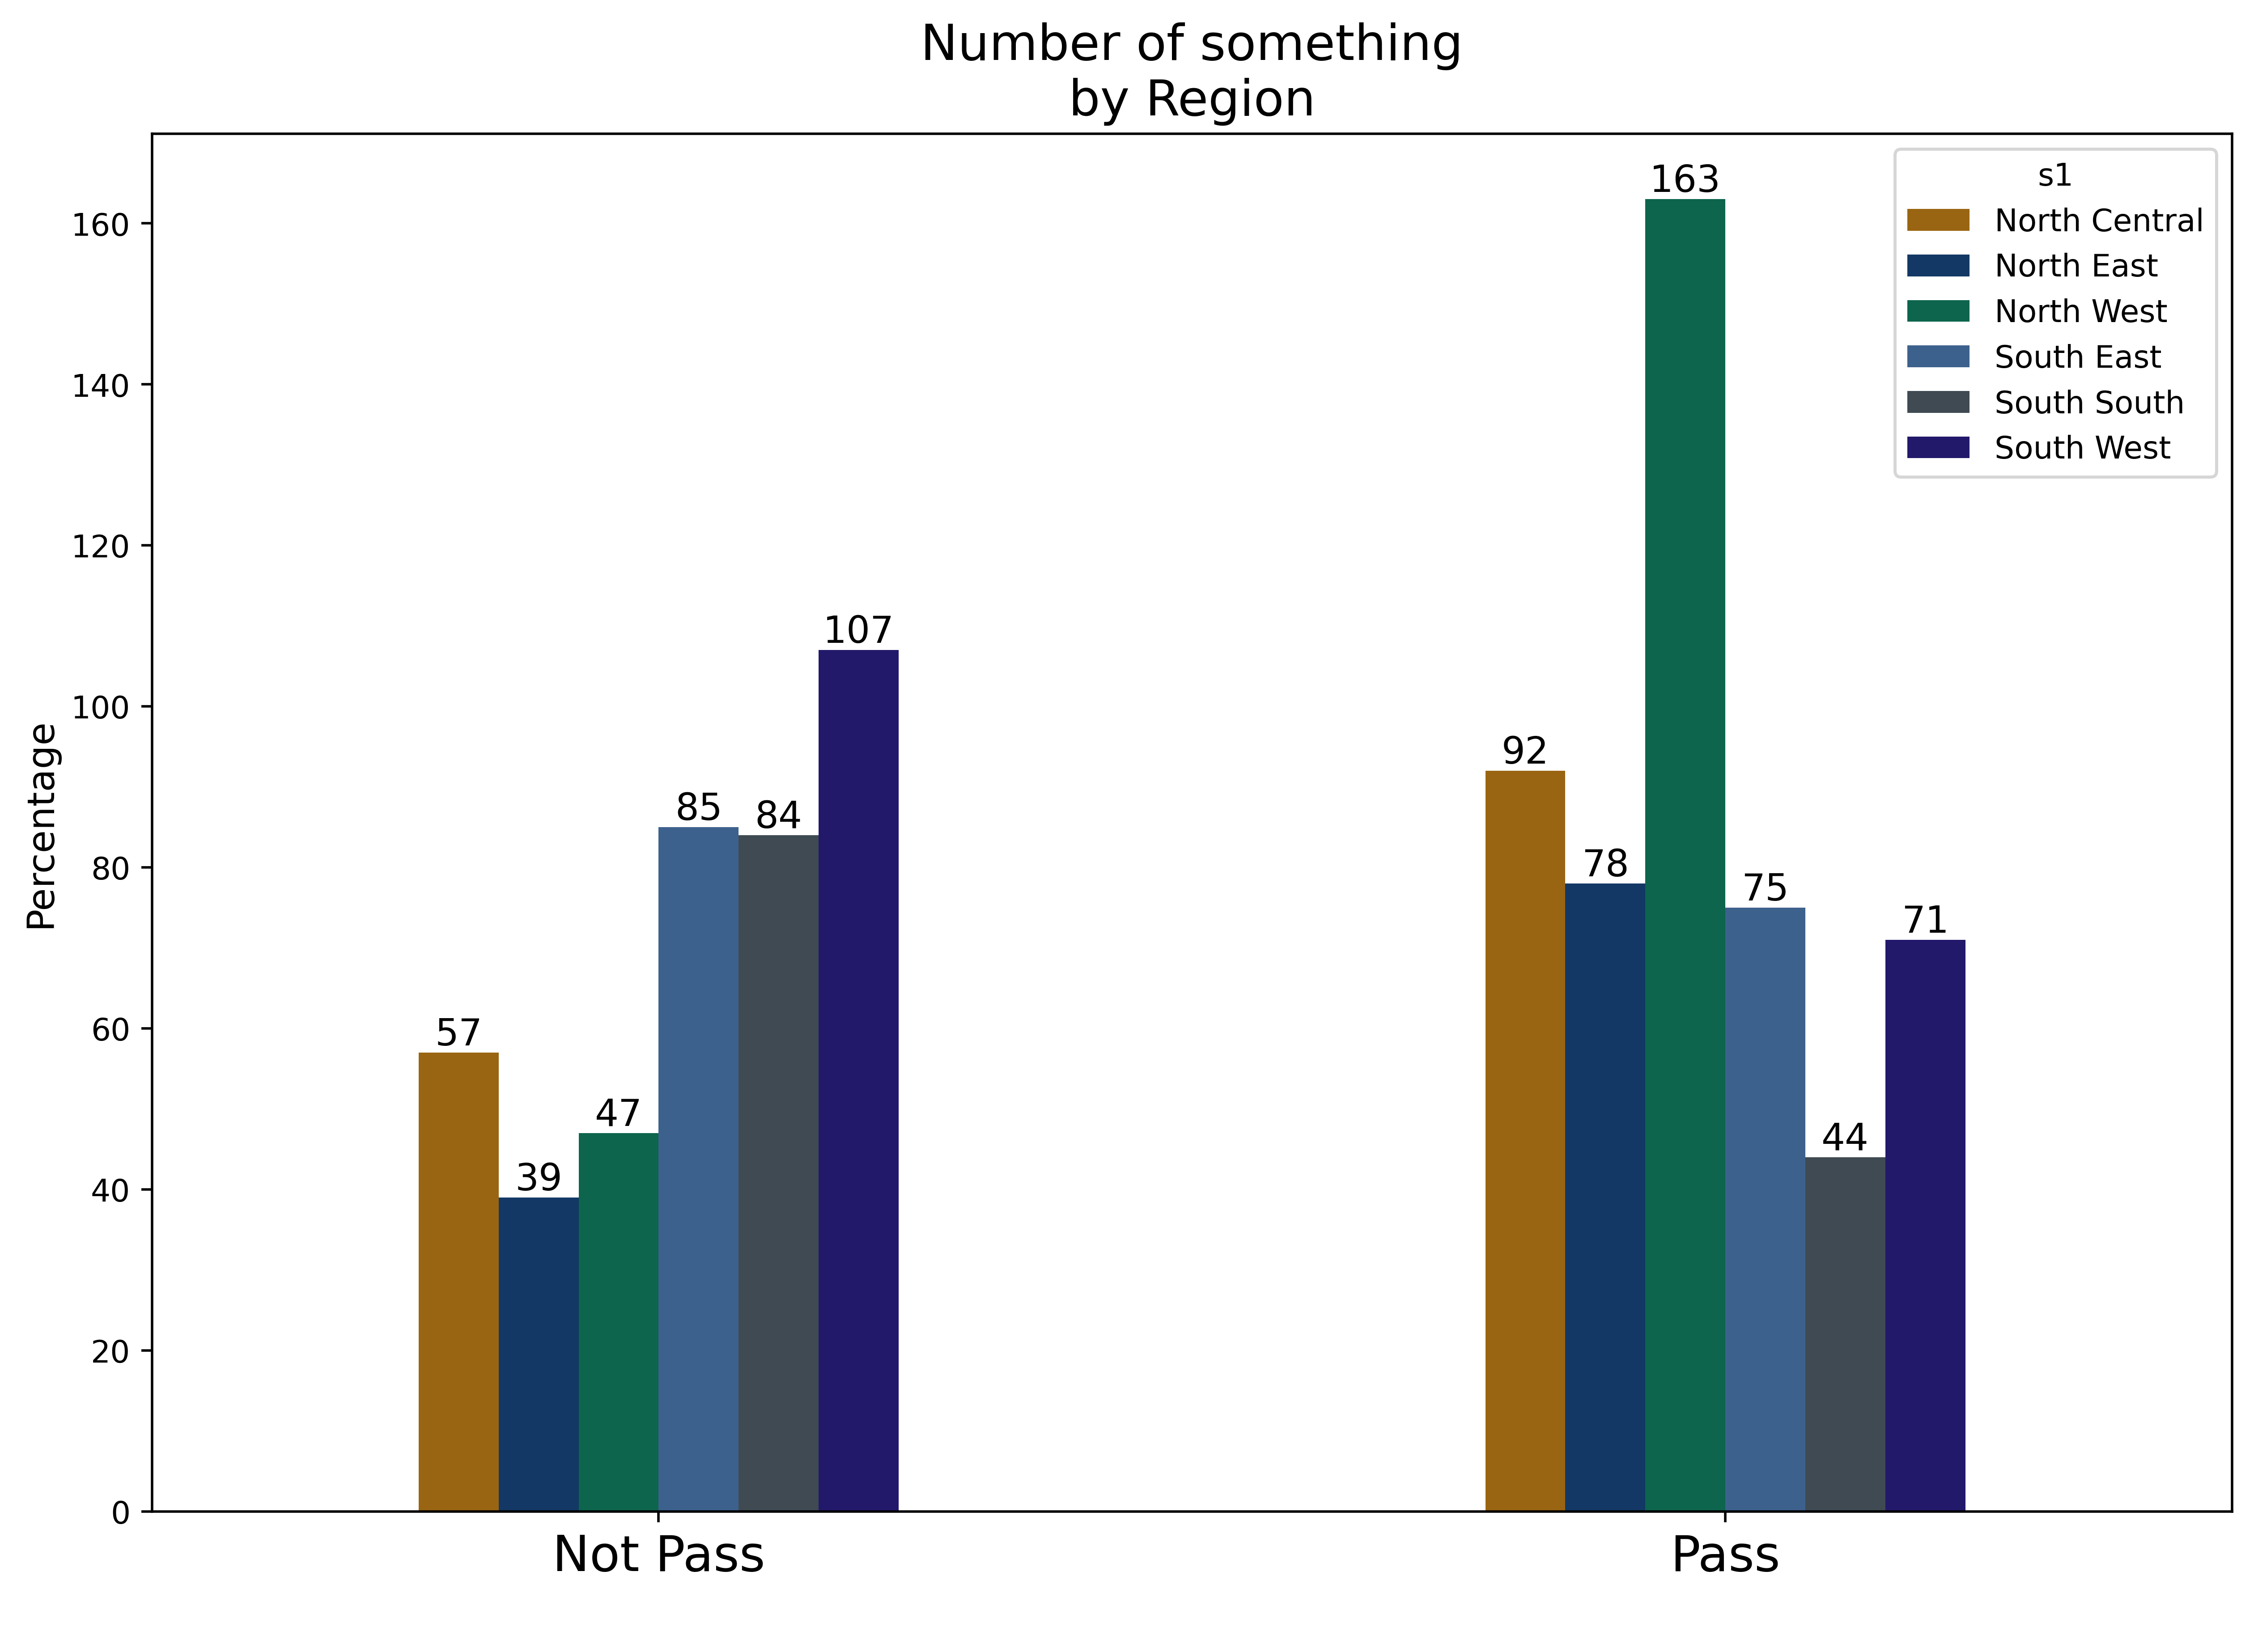

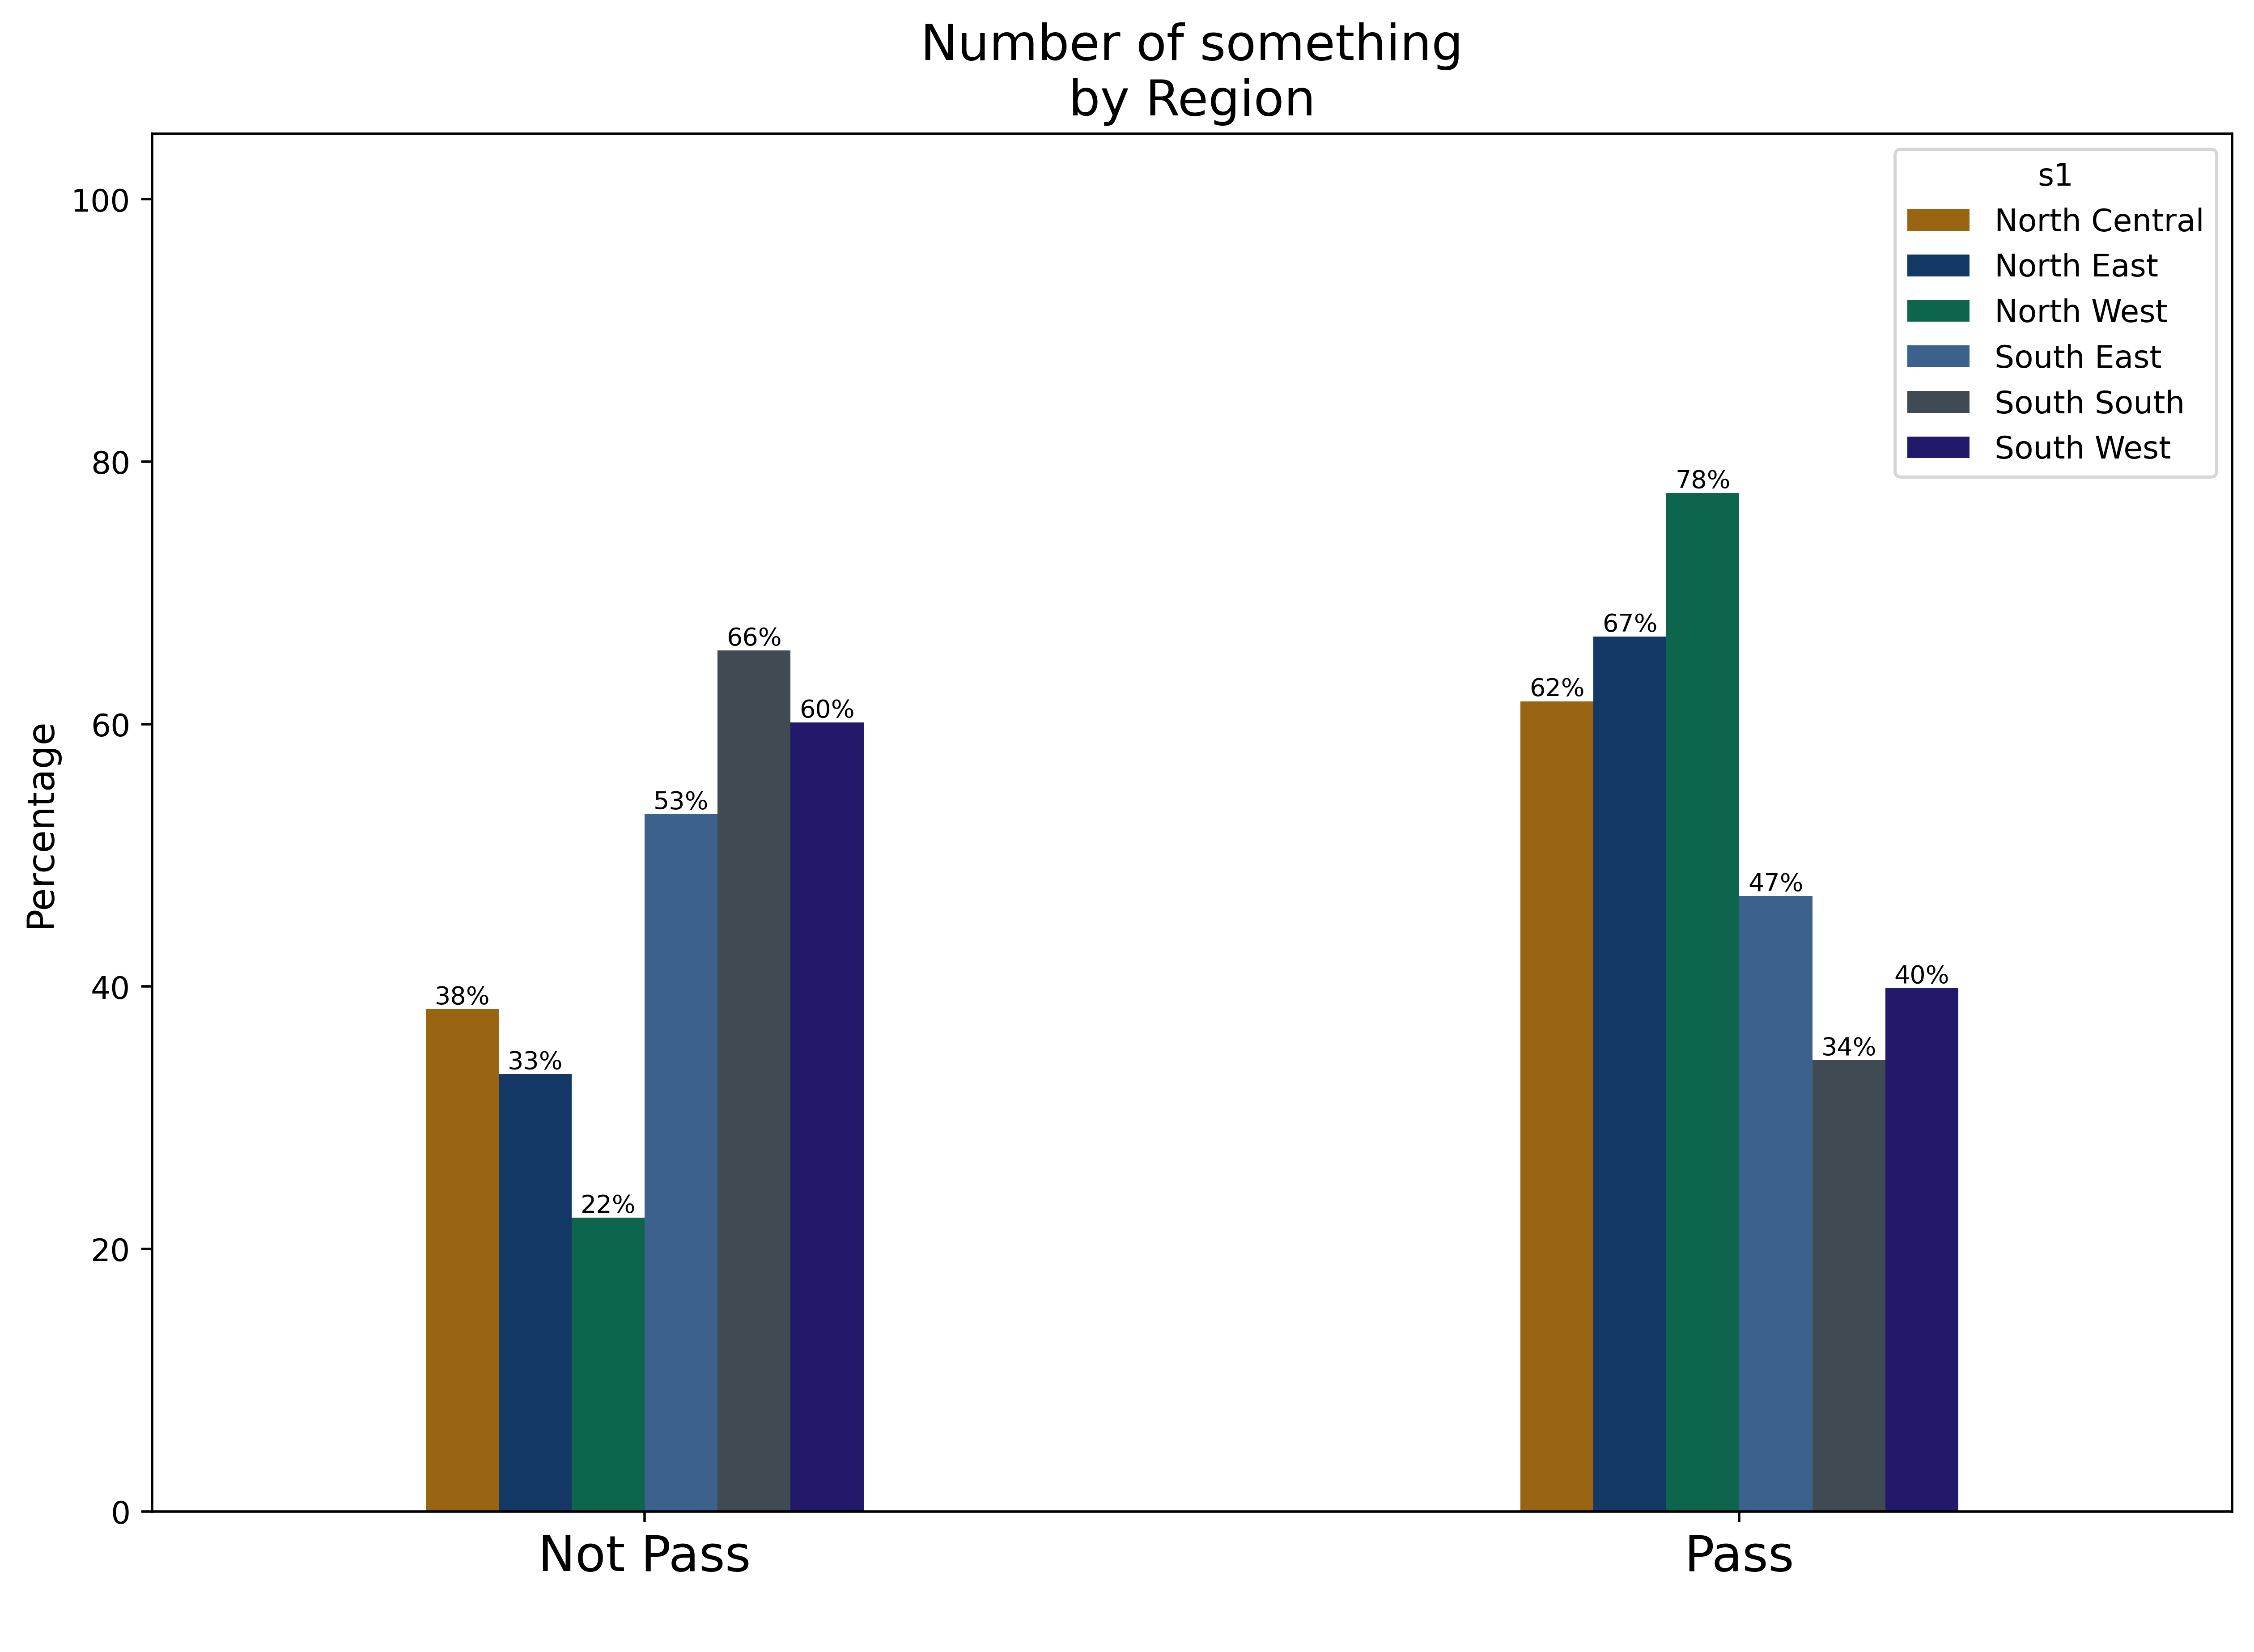

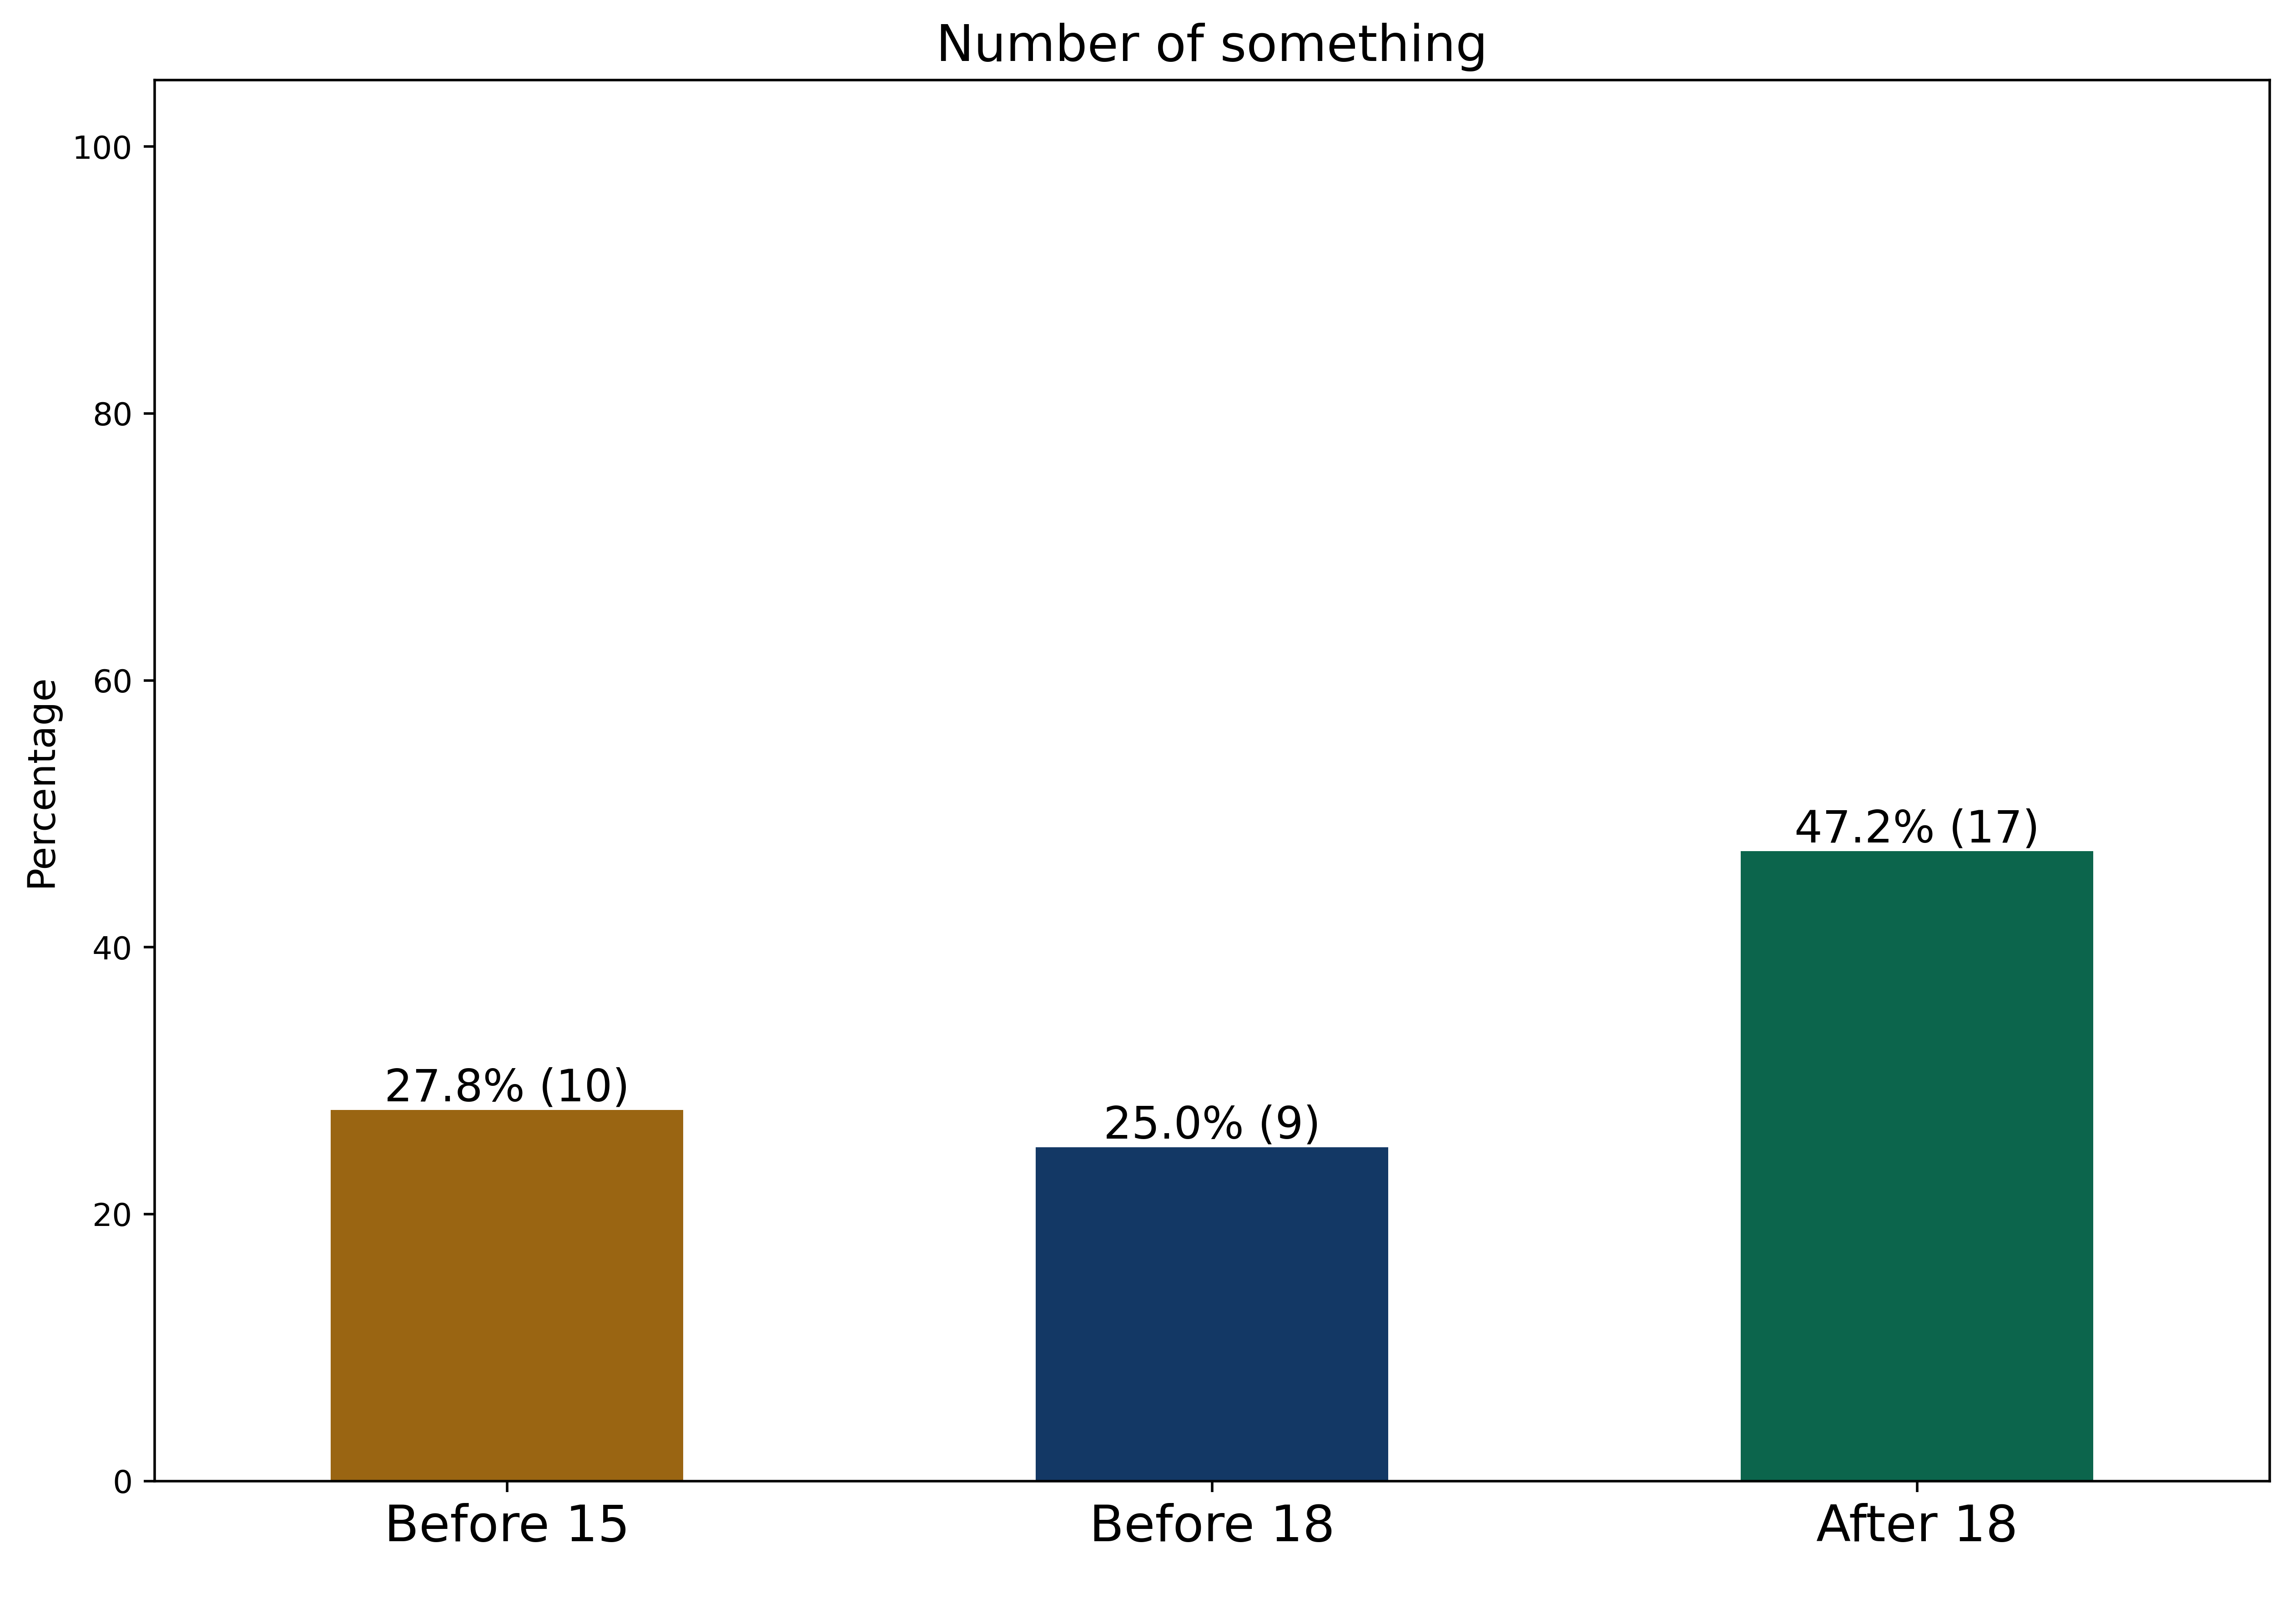

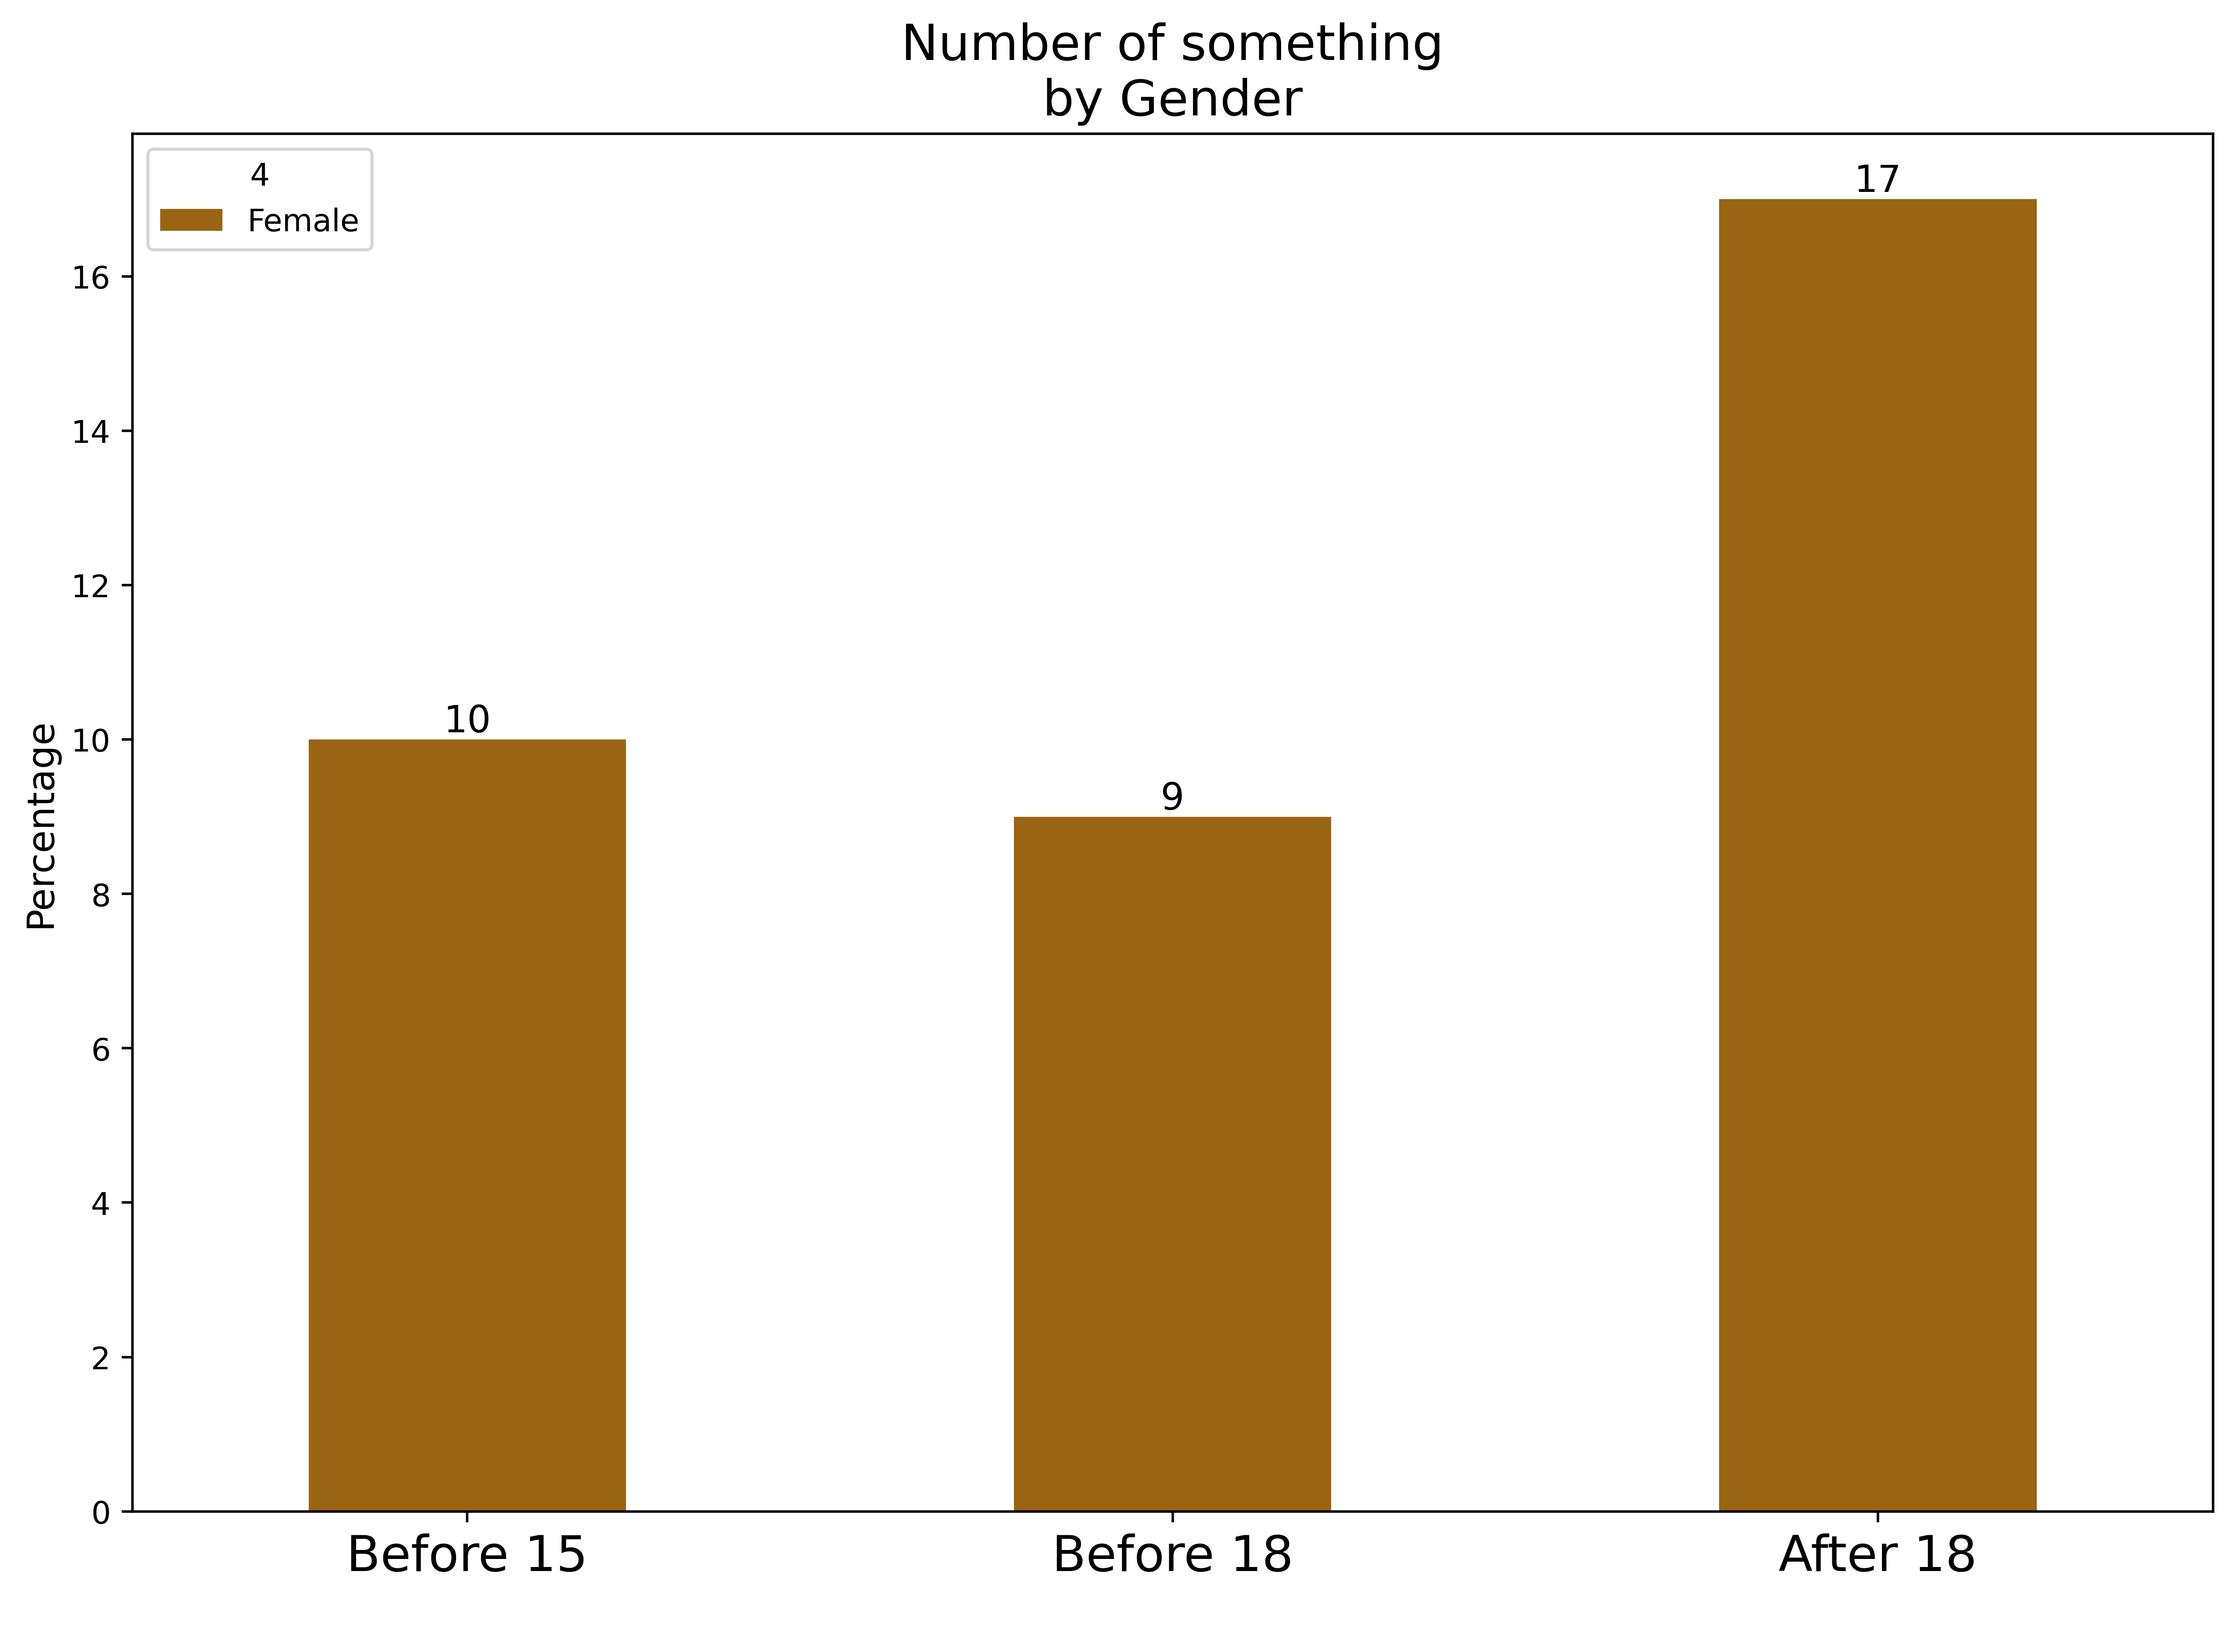

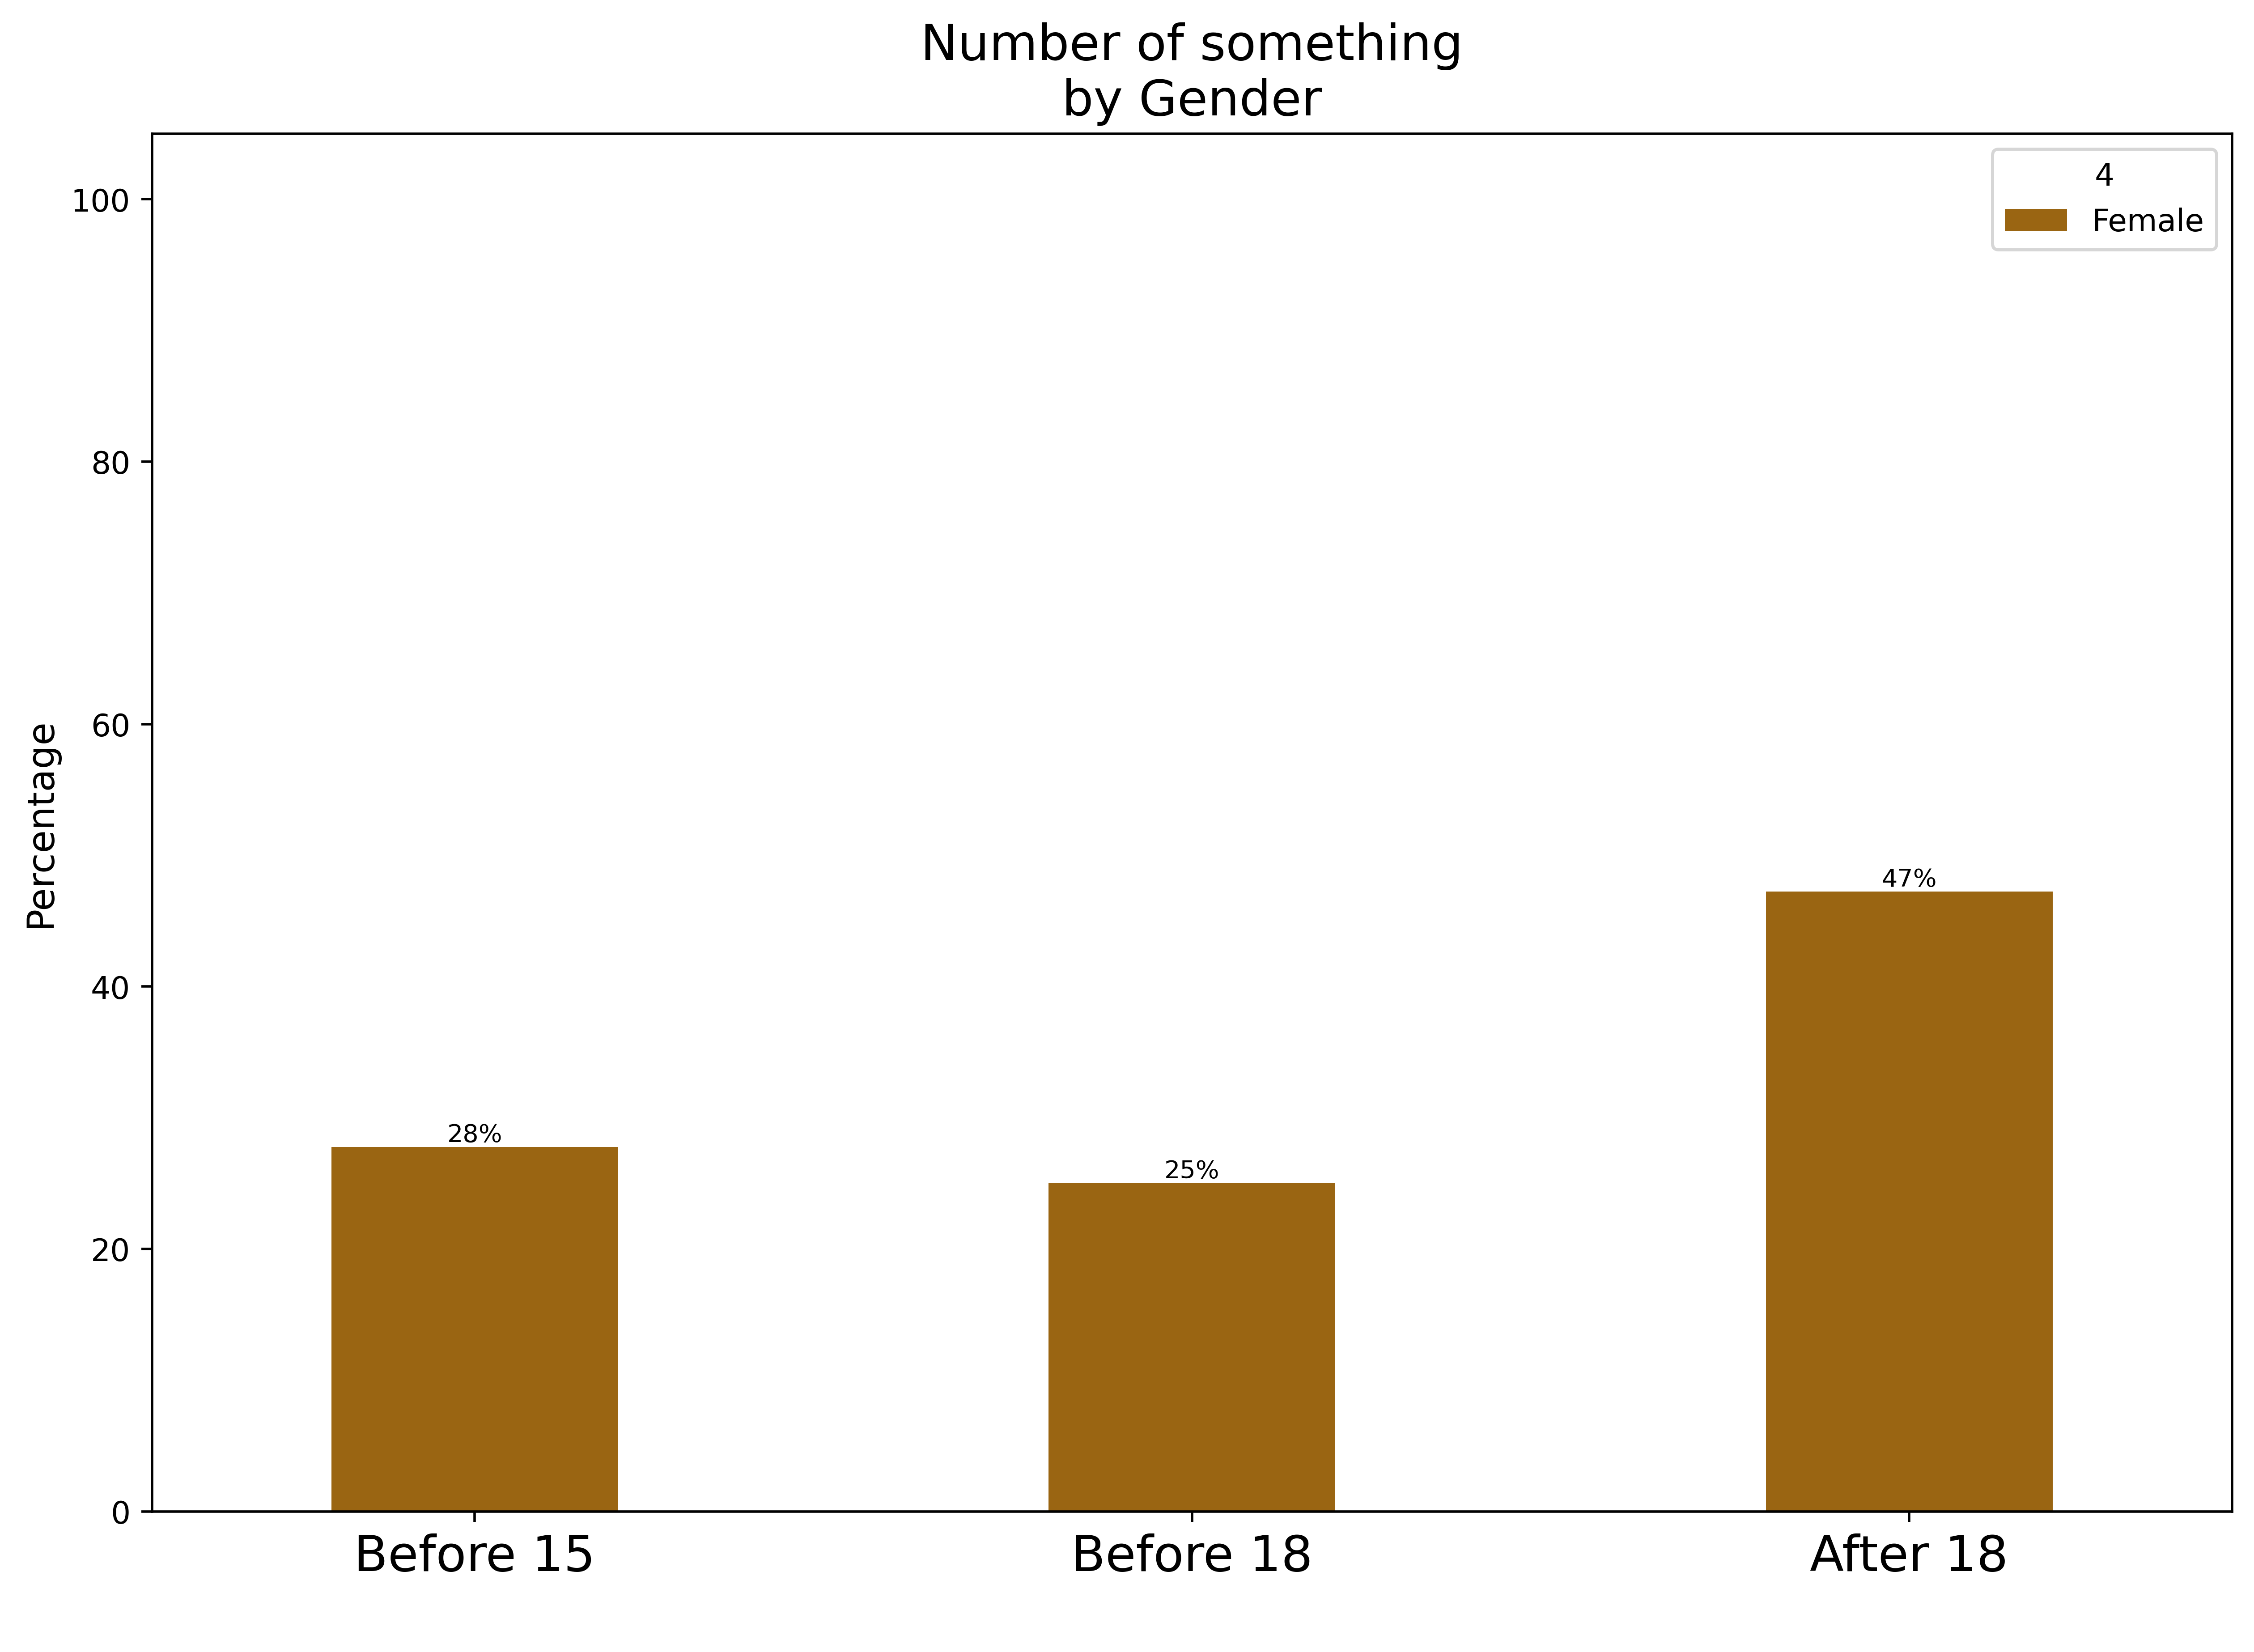

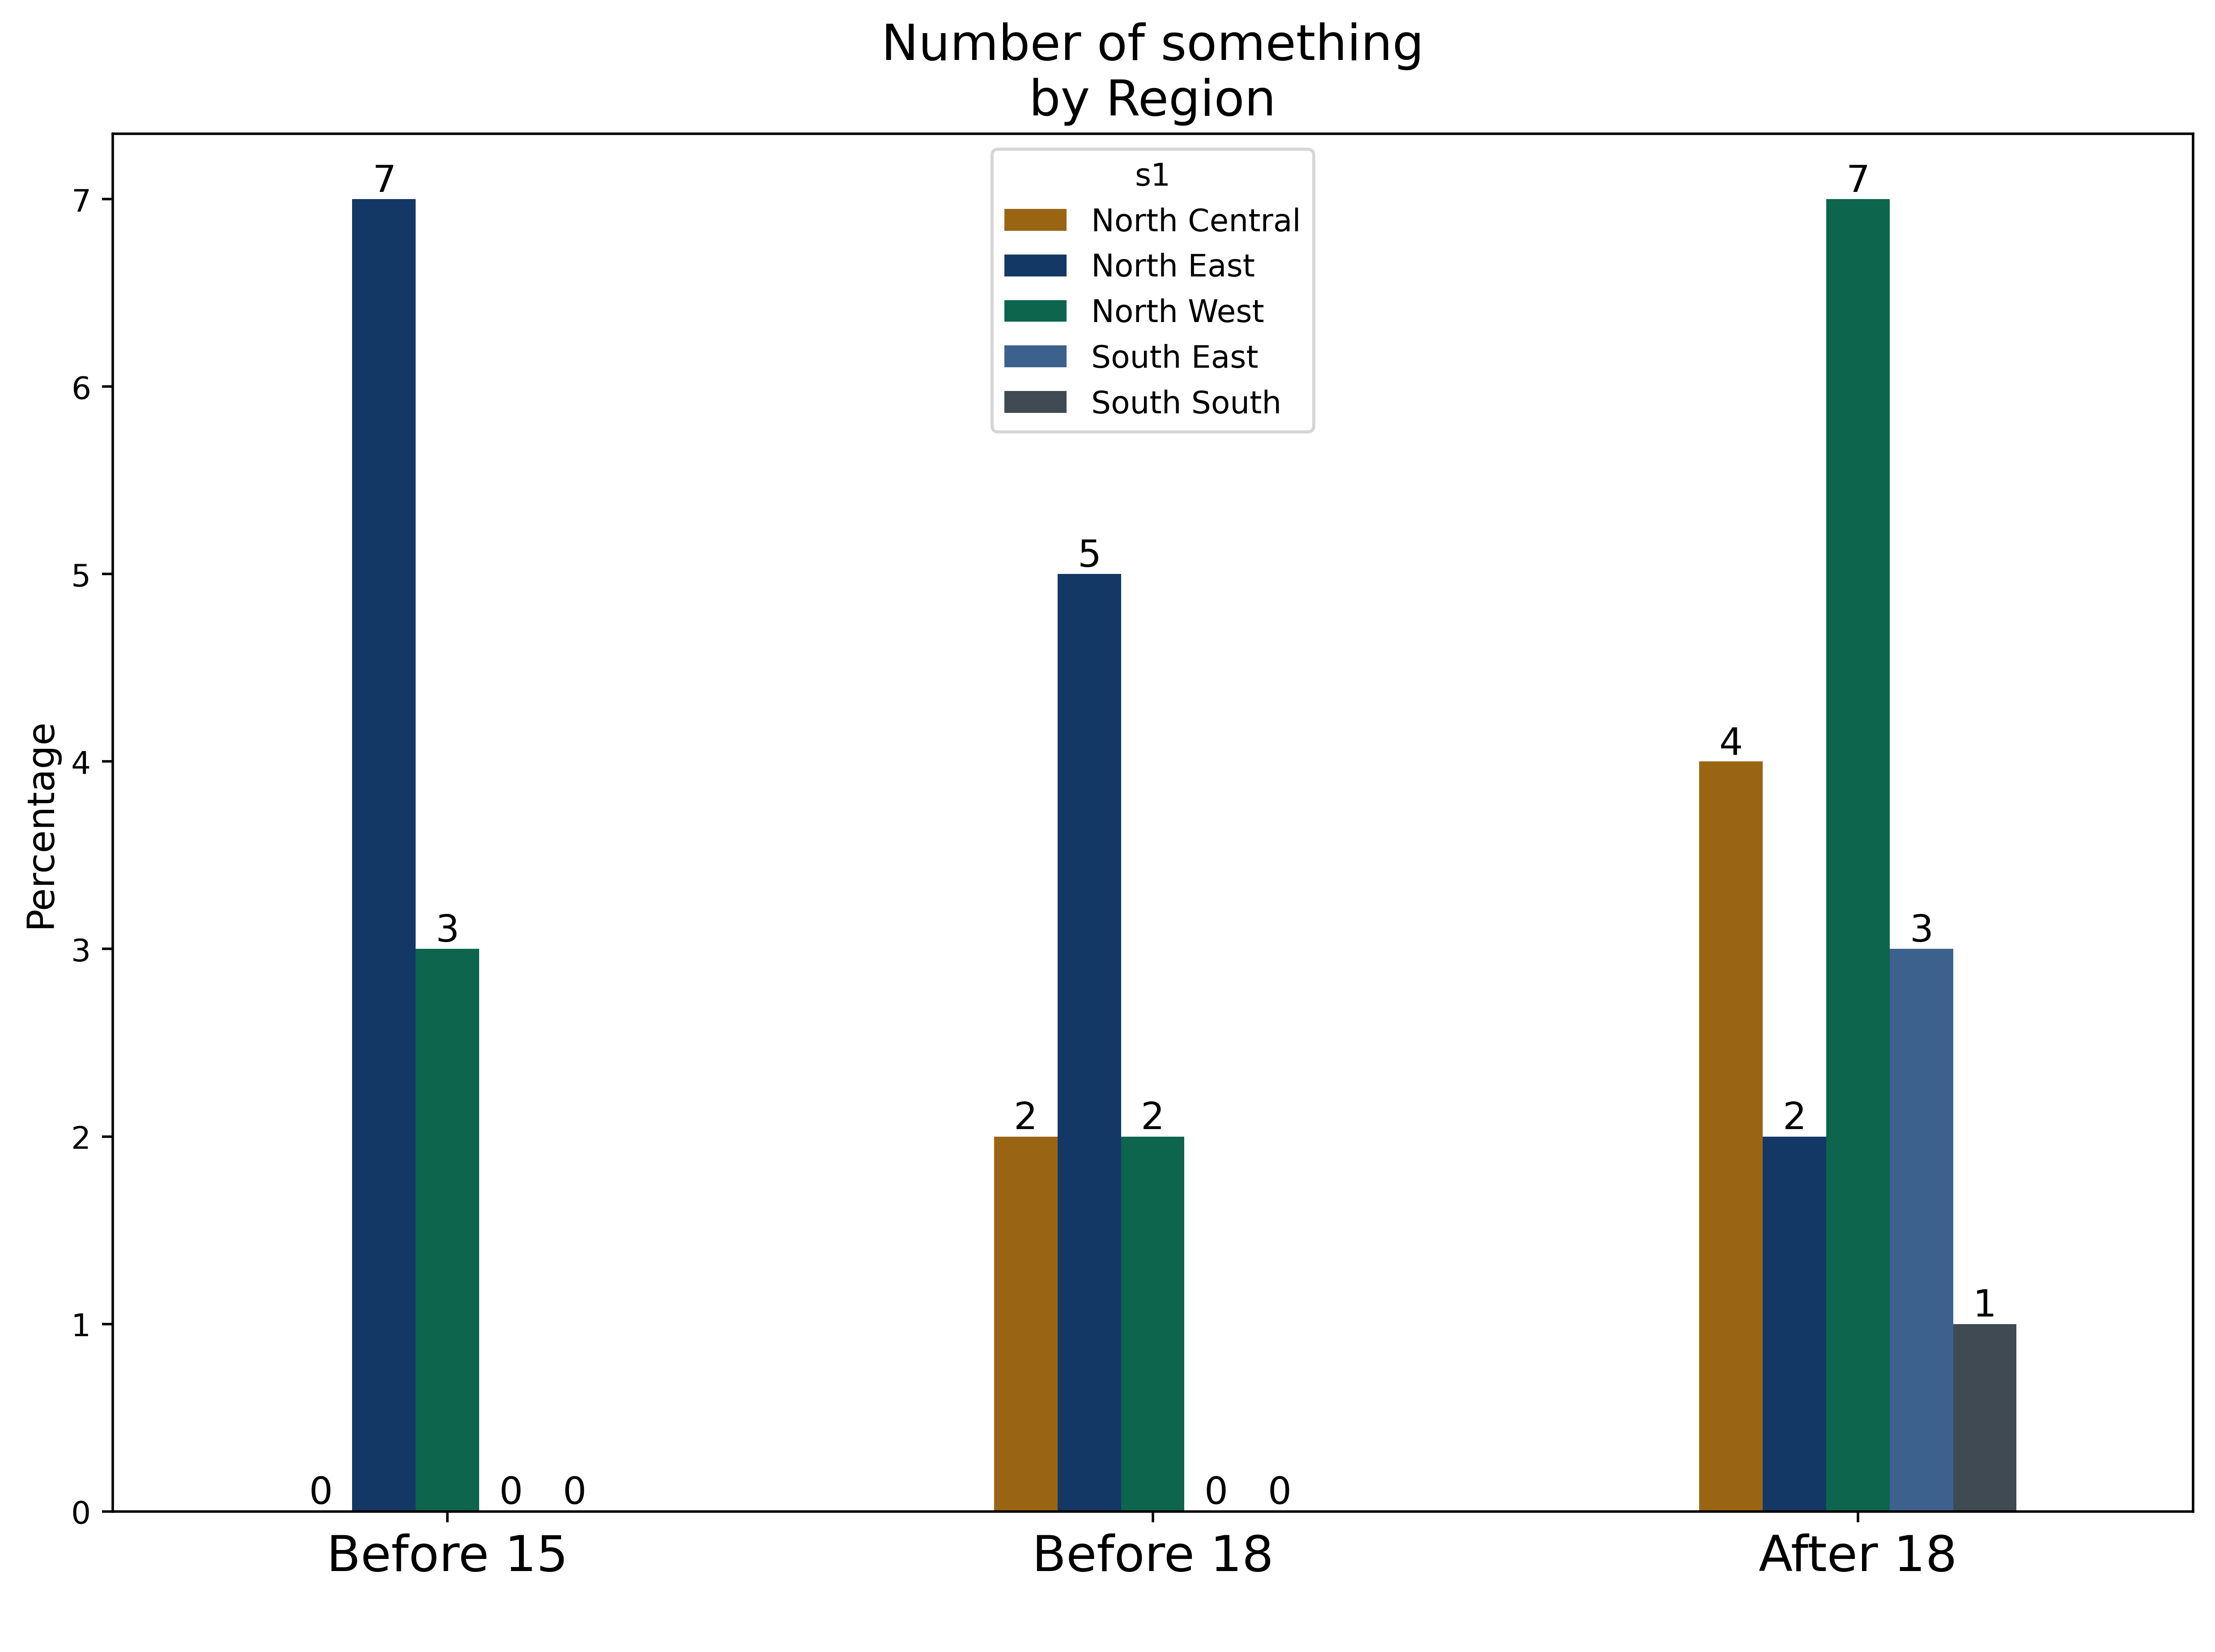

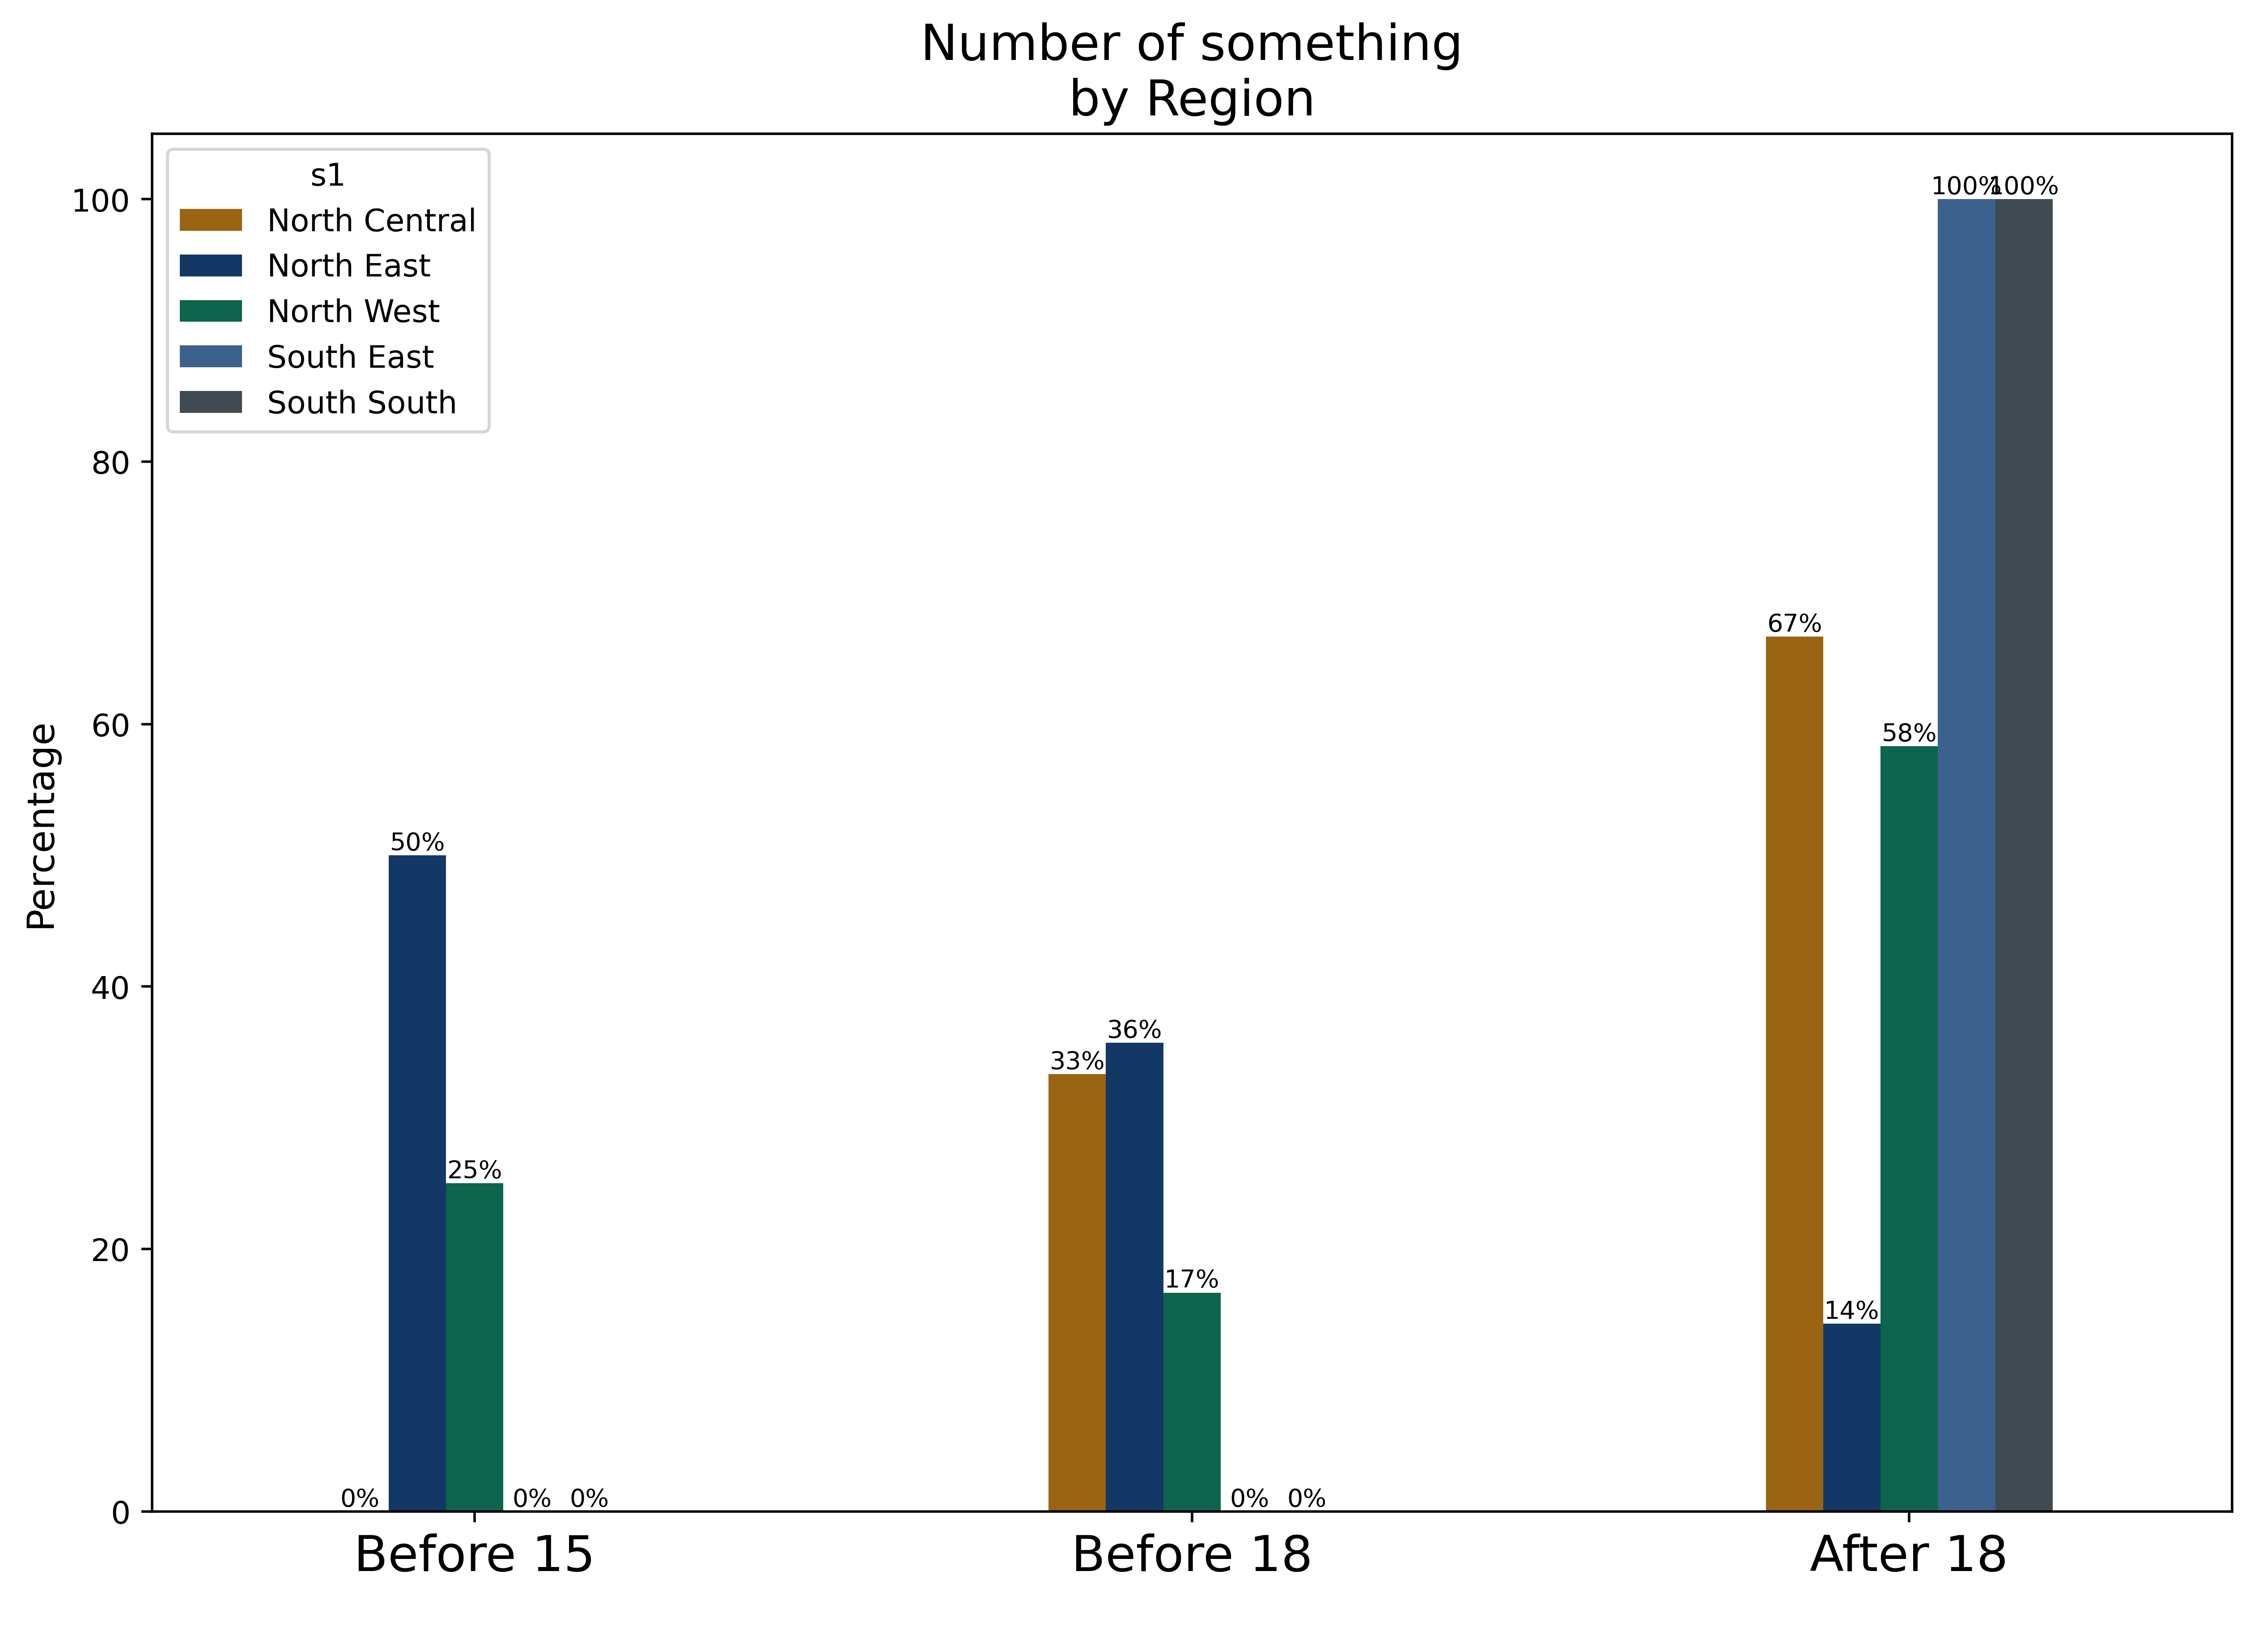

In [576]:
file_path1 = 'data/table1.xlsx'
file_path2 = 'data/table2.xlsx'
azobe.visual_generation(file_path1, file_path2)